In [1]:
!pip install pyarrow --user

In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from matplotlib import pyplot as plt
from math import floor

# loading `data.parquet` file
First we load data and get some information from it, to get basic understanding and general view on the data.

In [3]:
df = pq.read_table('data/data.parquet').to_pandas()

now lets look on columns, whether they match github description:

In [4]:
df.columns

Index(['MachineId', 'MeasurementId', 'Pressure'], dtype='object')

Column `MachineId` represents one machine as mentioned on github.
I want to understand what is meant by definition of _MeasurementId_ column, which says _MeasurementId - Id of the measured cycle_. There are multiple possible ways how to understand it, so I will test two that seems most probable:
 - Does one `measured cycle` represents one measurement of one machine cycle?
 - Does one `measured cycle` represents complete measurement of one machine cycle?
 
Let's take a look at some example `MachineId` and check how many rows we have for it:

In [5]:
df['MachineId'].unique()[:5]

array(['0_0_0', '0_0_1', '0_0_2', '0_0_3', '0_1_0'], dtype=object)

In [6]:
df[df['MachineId'] == '0_0_0']

MachineId  MeasurementId  Pressure
0            0_0_0              0       0.0
1            0_0_0              0       0.0
2            0_0_0              0       0.0
3            0_0_0              0       0.0
4            0_0_0              0       0.0
...            ...            ...       ...
18226173     0_0_0           8724       0.0
18226174     0_0_0           8724       0.0
18226175     0_0_0           8724       0.0
18226176     0_0_0           8724       0.0
18226177     0_0_0           8724       0.0

[365338 rows x 3 columns]

__So there are two possible scenarios__

 1. From what we see above, it seems that one `MeasurementId` could represent one single measurement of machine cycle (thus _measured cycle_ in _Id of the measured cycle_ is not the same as _machine cycle_), as there is a lot of `MeasurementId`s. However, that would mean, that dataset has some duplicated rows, as they have all columns same.
 2. Another scenario, could be in such way, that one row represents one technical measurement, and that _measured cycle_ is the same as _machine cycle_. In that case, it's weird that each single measurement does not have its on ID, so we must rely on rows order. 
 
Also, after quick look into `labels.csv` file, it has less than 30k rows. So if we are going to test first scenario, it means, that lot of data (single measurements) are missing in `labels.csv` and that _Slow start_ and _Slow end_ columns represents whether the single measurement happened during slow start or slow end (or nothing).

In case of the second scenario, `labels.csv` file could be ok.

Let's drop duplicates and try to plot data, to see whether correct understanding could be the first way (i.e. one `MeasurementId` represents single measurement of _machine cycle_ which consits of multiple `MeasurementId`s):

# Testing first way - suppose that `MeasurementId` represents single measurement

In [7]:
df = df.drop_duplicates().reset_index()

## Let's get some sample of the data and plot it
As this dataset is time series with main focus on pressure changing in time (according to task description), we will firstly plot pressure in time, over the individual measurements on some randomly chosen machines

In [8]:
sample_charts_machines = np.random.choice(df['MachineId'].unique(), 12, replace=False)
sample_charts_machines

array(['71_0_0', '38_2_3', '76_2_2', '57_1_3', '6_0_1', '36_2_1',
       '17_2_3', '21_2_1', '40_2_2', '56_2_0', '26_2_3', '7_2_2'],
      dtype=object)

According to the description, measure ID represents <i>Id of the measured cycle</i>. Above we saw measure IDs are integer numeric vales. So, in __this chart__ let's suppose these values represents order, in which measurements were done, but not the time difference between them. That means, that if we have IDs `[0,1,2,6,7,8]` for machine `x`, time between each measurement is same, although their difference isn't.

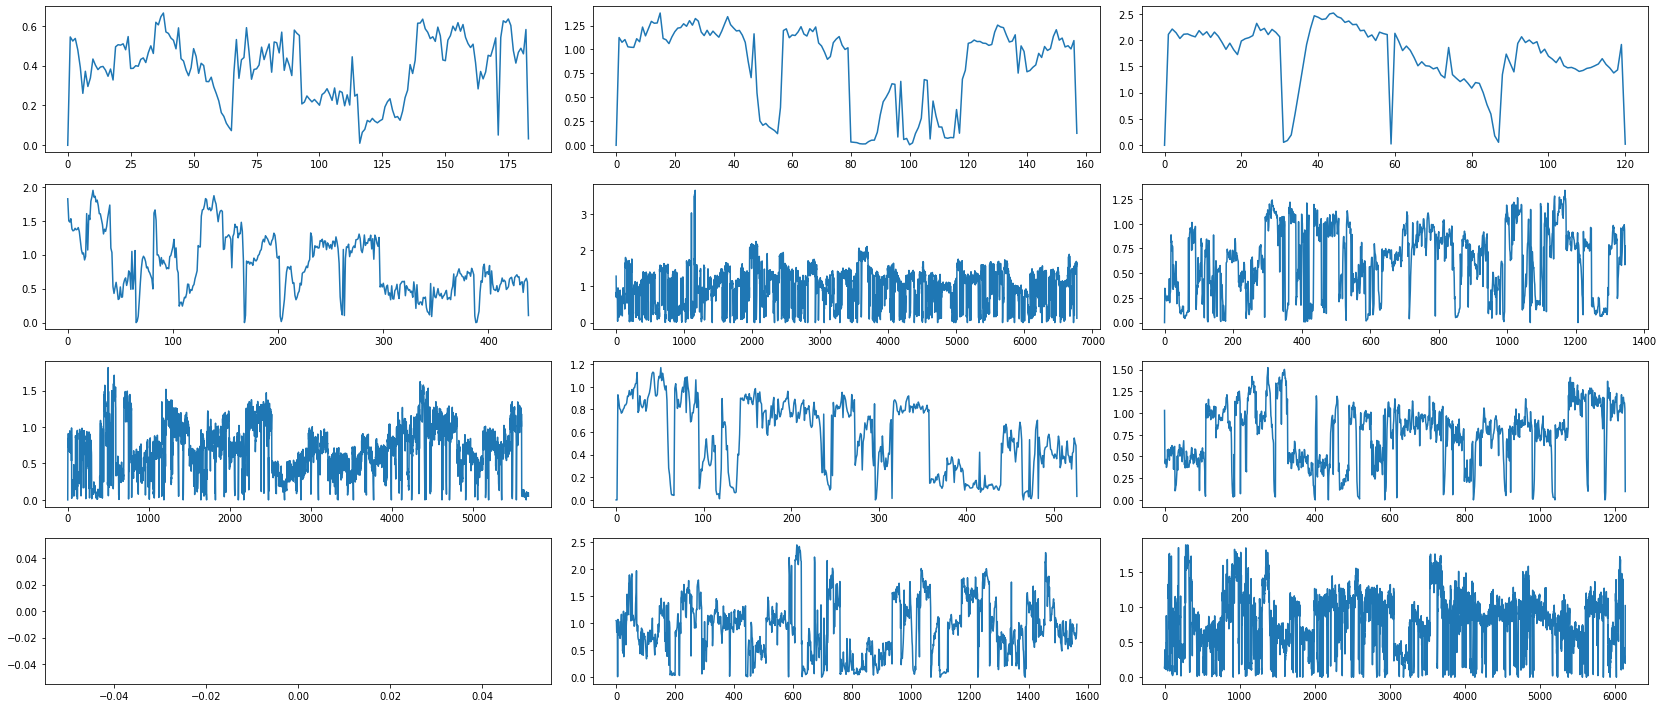

In [9]:
fig, charts = plt.subplots(nrows=4, ncols=3, figsize=(23,10))
plt.tight_layout()

#make charts flat array (as rows vs cols have no meaning, it's just for visualizing more on smaller space)
charts = [chart for row in charts for chart in row]

for idx,chart in enumerate(charts):
    measurements = df[df['MachineId'] == sample_charts_machines[idx]].sort_values(by='MeasurementId')[['Pressure','MeasurementId']]
    chart.plot(range(len(measurements['MeasurementId'])),measurements['Pressure'], linestyle='-')
    
plt.show()

Now we will repeat the same visualization as above, but we will assume that measurement ID represents also time difference, so on _x_ axis, we place measurements IDs directly, and we can expect some empty space (when some measurements were missing for given machine):

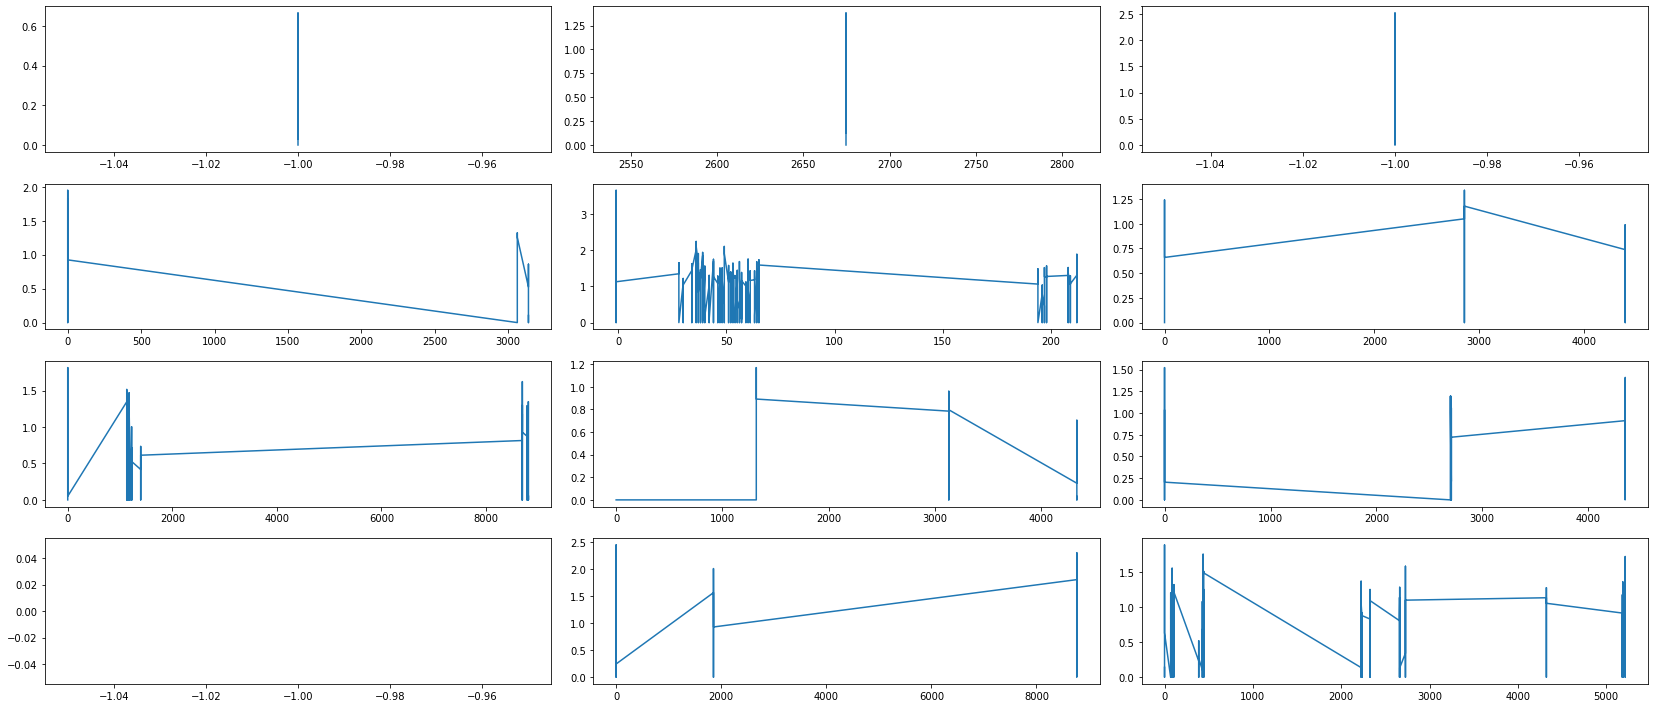

In [10]:
fig, charts = plt.subplots(nrows=4, ncols=3, figsize=(23,10))
plt.tight_layout()

#make charts flat array (as rows vs cols have no meaning, it's just for visualizing more on smaller space)
charts = [chart for row in charts for chart in row]

for idx,chart in enumerate(charts):
    measurements = df[df['MachineId'] == sample_charts_machines[idx]].sort_values(by='MeasurementId')[['Pressure','MeasurementId']]
    chart.plot(measurements['MeasurementId'],measurements['Pressure'], linestyle='-')
    
plt.show()

We see this is very 1) different from first visualization, 2) ugly, as there is A LOT of missing measurements IDs for each machine. However, we still don't know which interpretation from two sets of charts is correct, and whether the basic assumption (one `MeasurementId` represents single measurement) is correct

So it is possible that our initial interpretation that each measurement ID corresponds to exactly one measurement, is wrong. That would mean that measurement ID represents full process of multiple measurements.

That would mean following:
 - that we need to rely just on rows order, as there is no unique identifier
 - and that we cannot deduplicate rows, as it is possible that two rows represents two actual measurements, with one measurement ID (and pressure was same --> rows were completely identical)
 
Let's test whether there are some rows where measurement ID and machine ID are same, but pressure is different:

In [11]:
len(df[['MeasurementId','MachineId']].drop_duplicates())

27385

In [12]:
len(df[['MeasurementId','MachineId','Pressure']].drop_duplicates())

4010530

From this we can see that initial interpreation was wrong. One row actually represents one measurement, but one `MeasurementId` represents full _machine cycle_, consisting from multiple measurements. So let's test the second understanding in next chapter.

# Testing second way - suppose that `MeasurementId` represents full measurement of _machine cycle_
...and that individual measurements are represented just by rows in given order

In [13]:
df = pq.read_table('data/data.parquet').to_pandas()

We reloaded dataset and now we will load also labels file

In [14]:
labels = pd.read_csv('data/labels.csv')
labels

MachineId  MeasurementId PumpFailed SlowStart SlowEnd
0         0_0_0              0      False     False   False
1         0_0_1             -1        NaN       NaN     NaN
2         0_0_2              0      False     False   False
3         0_0_3              0       True     False   False
4         0_1_0             -1        NaN       NaN     NaN
...         ...            ...        ...       ...     ...
27380    10_0_2           8833      False     False   False
27381    10_0_3           8833      False     False   False
27382    10_0_0           8834      False     False   False
27383    10_0_1           8834      False     False    True
27384    10_0_3           8834      False     False   False

[27385 rows x 5 columns]

As we can see, labels have same number of rows, as there is unique rows in dataset file, when unique row is based on `MeasurementId` and `MachineId` columns. This can actually mean, that second assumption is correct, and that __one MeasurementId represents full machine cycle, and individual measurements are represented by rows__.

So let's try to plot charts or randomly selected machine cycles. We will selected several machines and several measurements cycles for each machine

## Sample data selection

In [15]:
sample_charts_machines = np.random.choice(df['MachineId'].unique(), 40, replace=False) #select first some MachineIds -> so that later we will select only measurements Ids that were run for given machine Id (there are gaps in measurement Ids)
df_sample_machines = df[df['MachineId'].isin(sample_charts_machines)]

lets show measurements we have for each of selected machines

In [16]:
df_sample_machines.groupby('MachineId').aggregate({'MeasurementId': lambda x: set(x)})

MeasurementId
MachineId                                                   
0_0_0      {0, 2052, 8199, 8209, 2074, 8251, 6217, 6218, ...
11_2_2                                      {4811, -1, 1367}
14_0_1     {2560, 2561, 2562, 2056, 2571, 4627, 4628, 462...
15_2_0                                            {1260, -1}
15_3_3                                            {1048, -1}
16_2_2                                                  {-1}
17_0_0     {1155, 8707, 1158, 1160, 1165, 1166, 1172, 181...
17_2_1     {1174, 1175, 1177, 1184, 1194, 1219, 1221, 878...
1_0_2      {3584, 3585, 3591, 2572, 1039, 1042, 3611, 361...
20_3_0                                                  {-1}
20_3_1                                                  {-1}
22_0_1                                                  {-1}
22_0_2                                                {8232}
22_1_3                                                {1351}
22_3_1                                            {8233, -1}
25_2_3     {3840, 2177, 3842, 2179, 3843, 3844, 2182, 219...
28_2_3     {2573, 2582, 2584, 1946, 2590, 2466, 4259, 426...
29_0_1                                            {4342, -1}
2_2_0      {3, 15, 1040, 17, 18, 20, 1050, 27, 1062, 1065...
32_0_1                                            {2995, -1}
33_1_2     {2944, 4353, 4354, 4355, 4356, 2186, 2957, 295...
34_0_0                                                {2219}
36_2_1                                      {4393, 2859, -1}
41_0_1                                                {2759}
46_2_0                                            {2963, -1}
50_0_0                                                  {-1}
50_0_1                                                  {-1}
53_4_2                                                  {-1}
56_0_1                                            {2836, -1}
59_0_0              {2890, 4371, 4373, 4375, 4376, 2877, -1}
67_2_2                                                {3096}
73_3_1                                                  {-1}
74_3_0                                                  {-1}
76_2_0                                                  {-1}
78_0_0                                                  {-1}
79_0_0                                                  {-1}
79_0_3                                                  {-1}
7_0_2                                             {2678, -1}
7_1_3                                       {2218, -1, 4383}
7_4_0      {2753, 2564, 2604, 2606, 2610, 2612, 2644, 271...

Ok so we will select ideally 3 random measurements for each machine. If it has less, we select less. In previous step, we could also select only machines with at least 3 measurements, but it could introduce bias in data (e.g., what if less/more measured machines are less/more faulty?). Lets put this into dictionary format and with added list of measurements ids for each machine:

In [17]:
print(df_sample_machines.groupby('MachineId').aggregate({'MeasurementId':lambda x: set(x)}).rename({'MeasurementId':'measurements'},axis=1).to_dict(orient='index'))

{'0_0_0': {'measurements': {0, 2052, 8199, 8209, 2074, 8251, 6217, 6218, 6221, 6224, 6229, 2135, 8291, 2148, 7982, 8301, 2163, 6262, 6263, 2168, 6264, 6268, 6269, 6270, 2196, 2198, 2204, 2213, 8359, 2216, 6315, 6316, 2232, 2238, 8387, 8389, 8392, 8393, 8395, 8397, 8398, 8399, 2260, 215, 8407, 2270, 8414, 8416, 8420, 8422, 8425, 237, 8429, 8434, 8436, 8190, 8441, 8444, 2318, 8482, 2343, 8487, 2347, 8492, 2355, 8499, 8500, 6458, 6460, 6461, 6467, 6468, 6469, 6472, 6478, 6485, 6495, 353, 2412, 2425, 2452, 2455, 2457, 411, 412, 8610, 421, 2470, 2471, 2472, 8613, 428, 430, 441, 2518, 476, 478, 487, 2537, 507, 517, 2566, 2576, 8724, 2596, 2601, 2646, 2654, 657, 667, 671, 2720, 675, 676, 2728, 4781, 698, 699, 2751, 716, 4812, 4813, 731, 4830, 735, 2783, 738, 4837, 2791, 749, 4852, 4856, 2813, 2841, 2885, 2887, 854, 2917, 898, 905, 2953, 907, 2961, 2967, 2979, 2984, 3002, 3010, 963, 980, 988, 7931, 3054, 7937, 7938, 3091, 3097, 3106, 7945, 7946, 3119, 7947, 7948, 7949, 3131, 7950, 3136, 5193, 

now we will select individual measurements

In [18]:
selected = []
for m in sample_charts_machines:
    measurements_this_machine = df_sample_machines.groupby('MachineId').aggregate({'MeasurementId':lambda x: set(x)}).rename({'MeasurementId':'measurements'},axis=1).to_dict(orient='index')[m]['measurements']
    num_selected_measurements = min(3,len(measurements_this_machine)) #if possible, select ideally 3 measurements
    selected_measurements = np.random.choice(list(measurements_this_machine), num_selected_measurements, replace=False) #now we select only relevant measurements ids to already selected machine Ids
    selected.append({'machine_id':m, 'measurements':selected_measurements})

selected

[{'machine_id': '22_1_3', 'measurements': array([1351])},
 {'machine_id': '2_2_0', 'measurements': array([8263, 8648, 8660])},
 {'machine_id': '22_0_2', 'measurements': array([8232])},
 {'machine_id': '15_2_0', 'measurements': array([1260,   -1])},
 {'machine_id': '50_0_0', 'measurements': array([-1])},
 {'machine_id': '53_4_2', 'measurements': array([-1])},
 {'machine_id': '15_3_3', 'measurements': array([  -1, 1048])},
 {'machine_id': '50_0_1', 'measurements': array([-1])},
 {'machine_id': '36_2_1', 'measurements': array([2859,   -1, 4393])},
 {'machine_id': '41_0_1', 'measurements': array([2759])},
 {'machine_id': '14_0_1', 'measurements': array([2511, 4751, 3958])},
 {'machine_id': '46_2_0', 'measurements': array([  -1, 2963])},
 {'machine_id': '20_3_1', 'measurements': array([-1])},
 {'machine_id': '7_4_0', 'measurements': array([2644, 2621, 2604])},
 {'machine_id': '11_2_2', 'measurements': array([  -1, 1367, 4811])},
 {'machine_id': '7_1_3', 'measurements': array([  -1, 4383, 22

## Plotting charts
Now when we have selected machines and measurements, we will plot charts

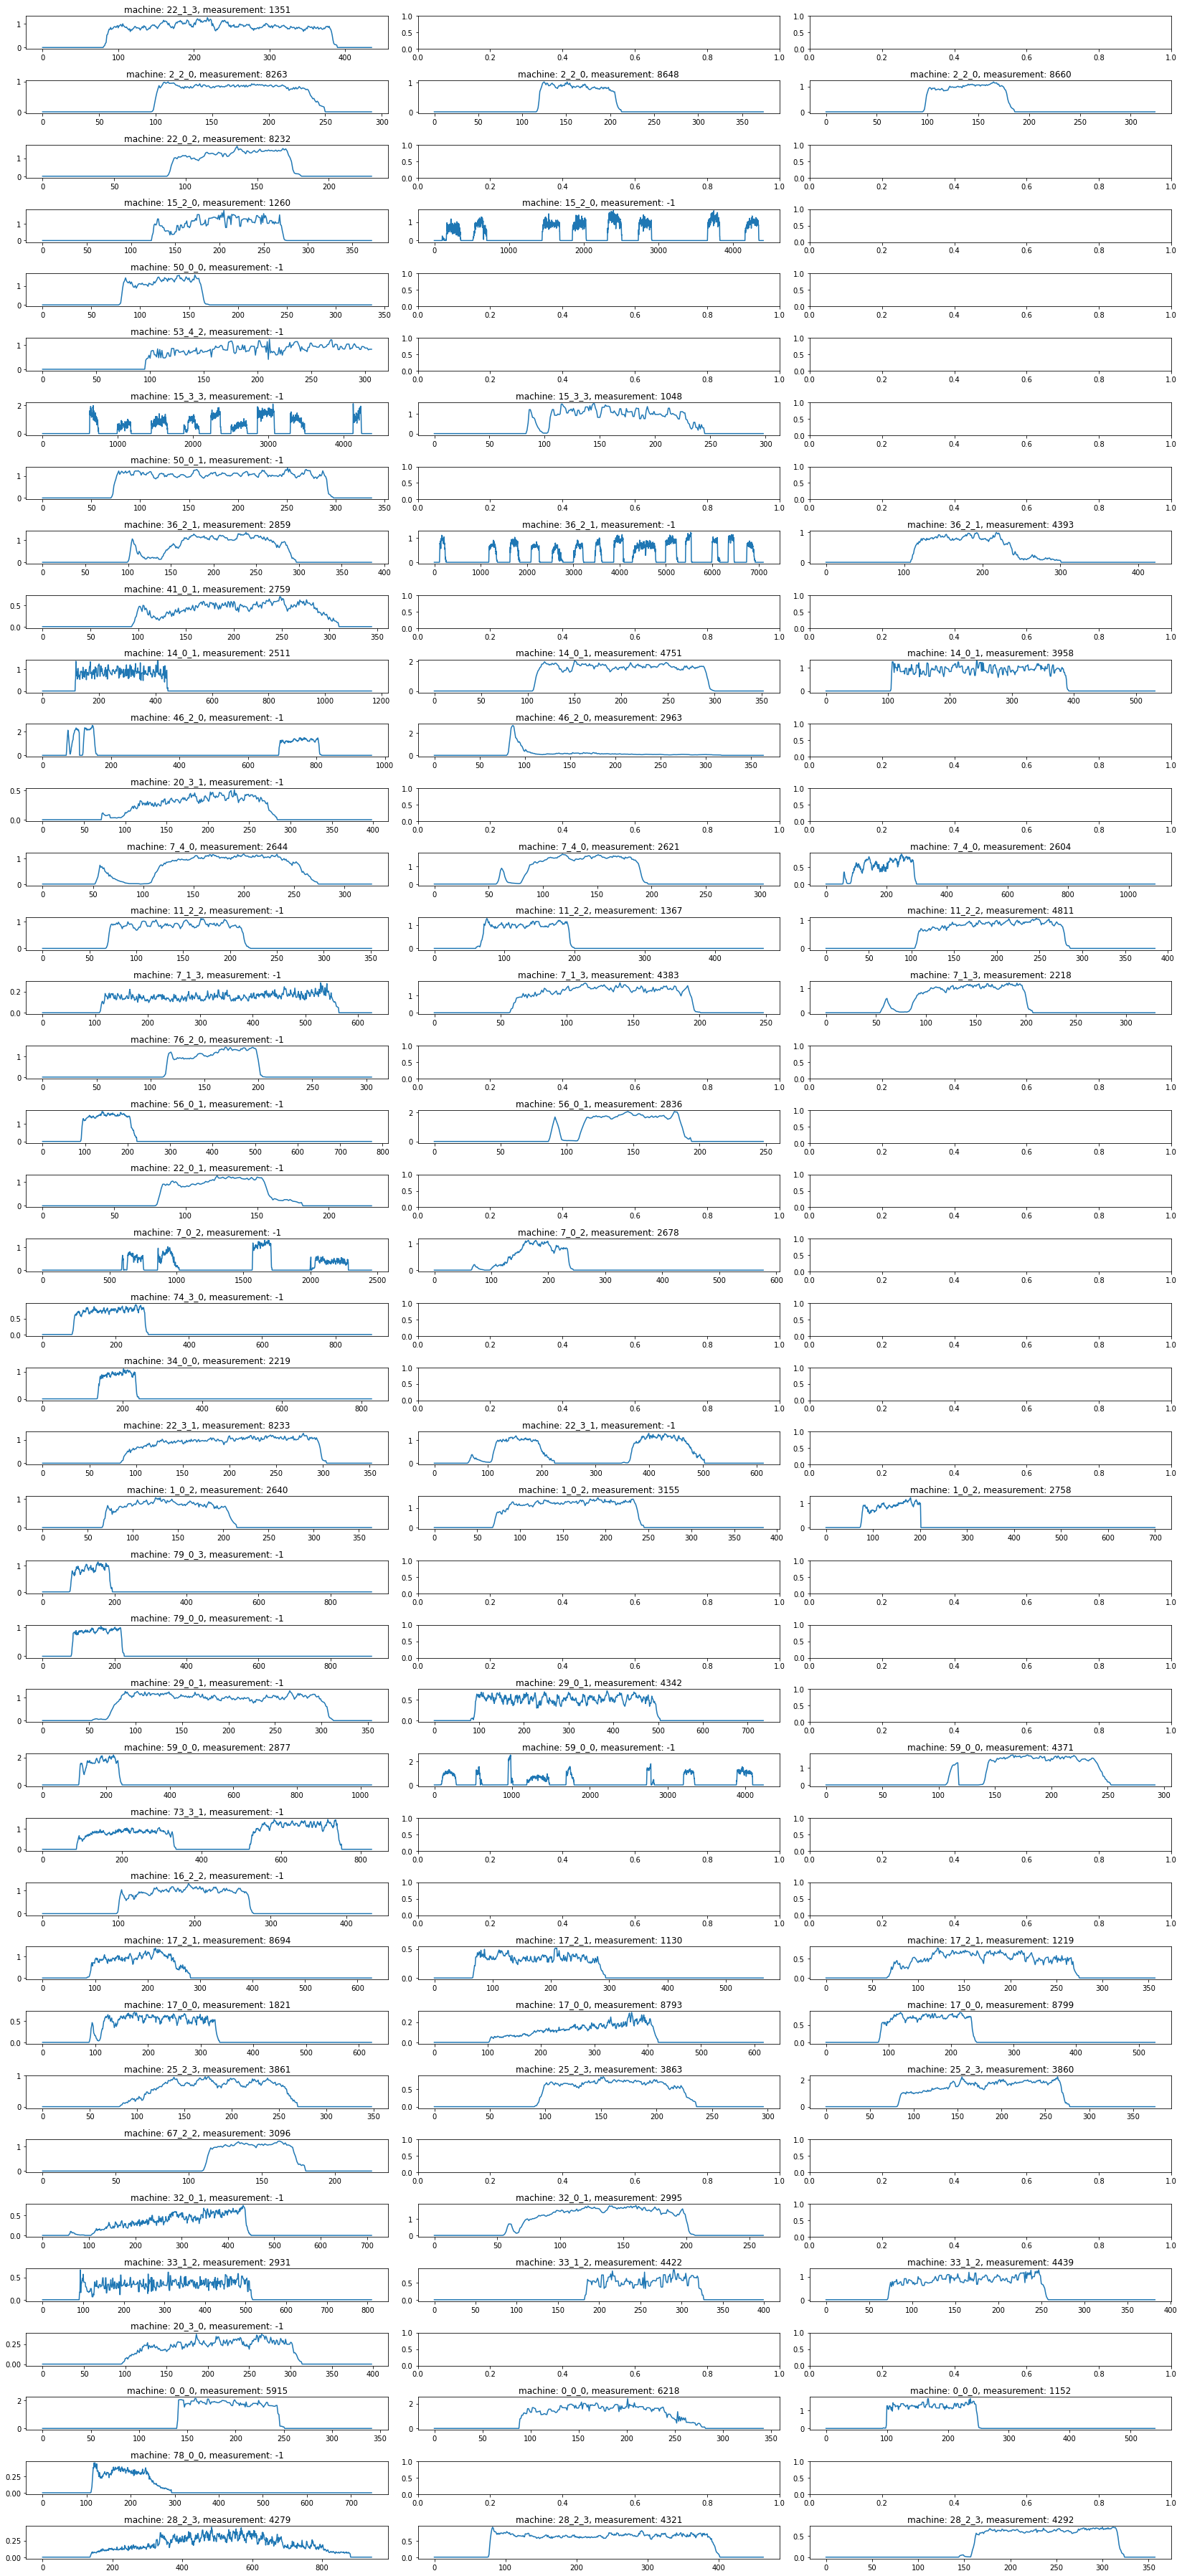

In [19]:
fig, charts = plt.subplots(nrows=40, ncols=3, figsize=(23,50))
temp_df = df[df['MachineId'].isin(sample_charts_machines)]

for machidx, mach in enumerate(selected):
    for measidx, meas in enumerate(mach['measurements']):
        pressure = temp_df[(temp_df['MachineId'] == mach['machine_id']) & (temp_df['MeasurementId'] == meas)]['Pressure']
        chart = charts[machidx][measidx]
        chart.plot(range(len(pressure)), pressure)
        chart.set_title(f"machine: {mach['machine_id']}, measurement: {meas}")

plt.tight_layout()        

Charts above seems to be reasonable. But we would also need to see labels corresponding to each measure (whether pump failed).

The purpose of that, is to check if we can visually disntiguish pump failure and ideally get some understanding of _how pump failure looks like_, so that we can decide whether a model should be built, or whether we may try some heuristic first

In [20]:
#joining not necessary
#temp_df_labels = temp_df.merge(labels, how='inner', left_on=['MachineId','MeasurementId'], right_on=['MachineId','MeasurementId'])
#temp_df_labels

## Plotting charts together with labels
Here we add labels to charts, they will be represented in form of colours

In [21]:
import math

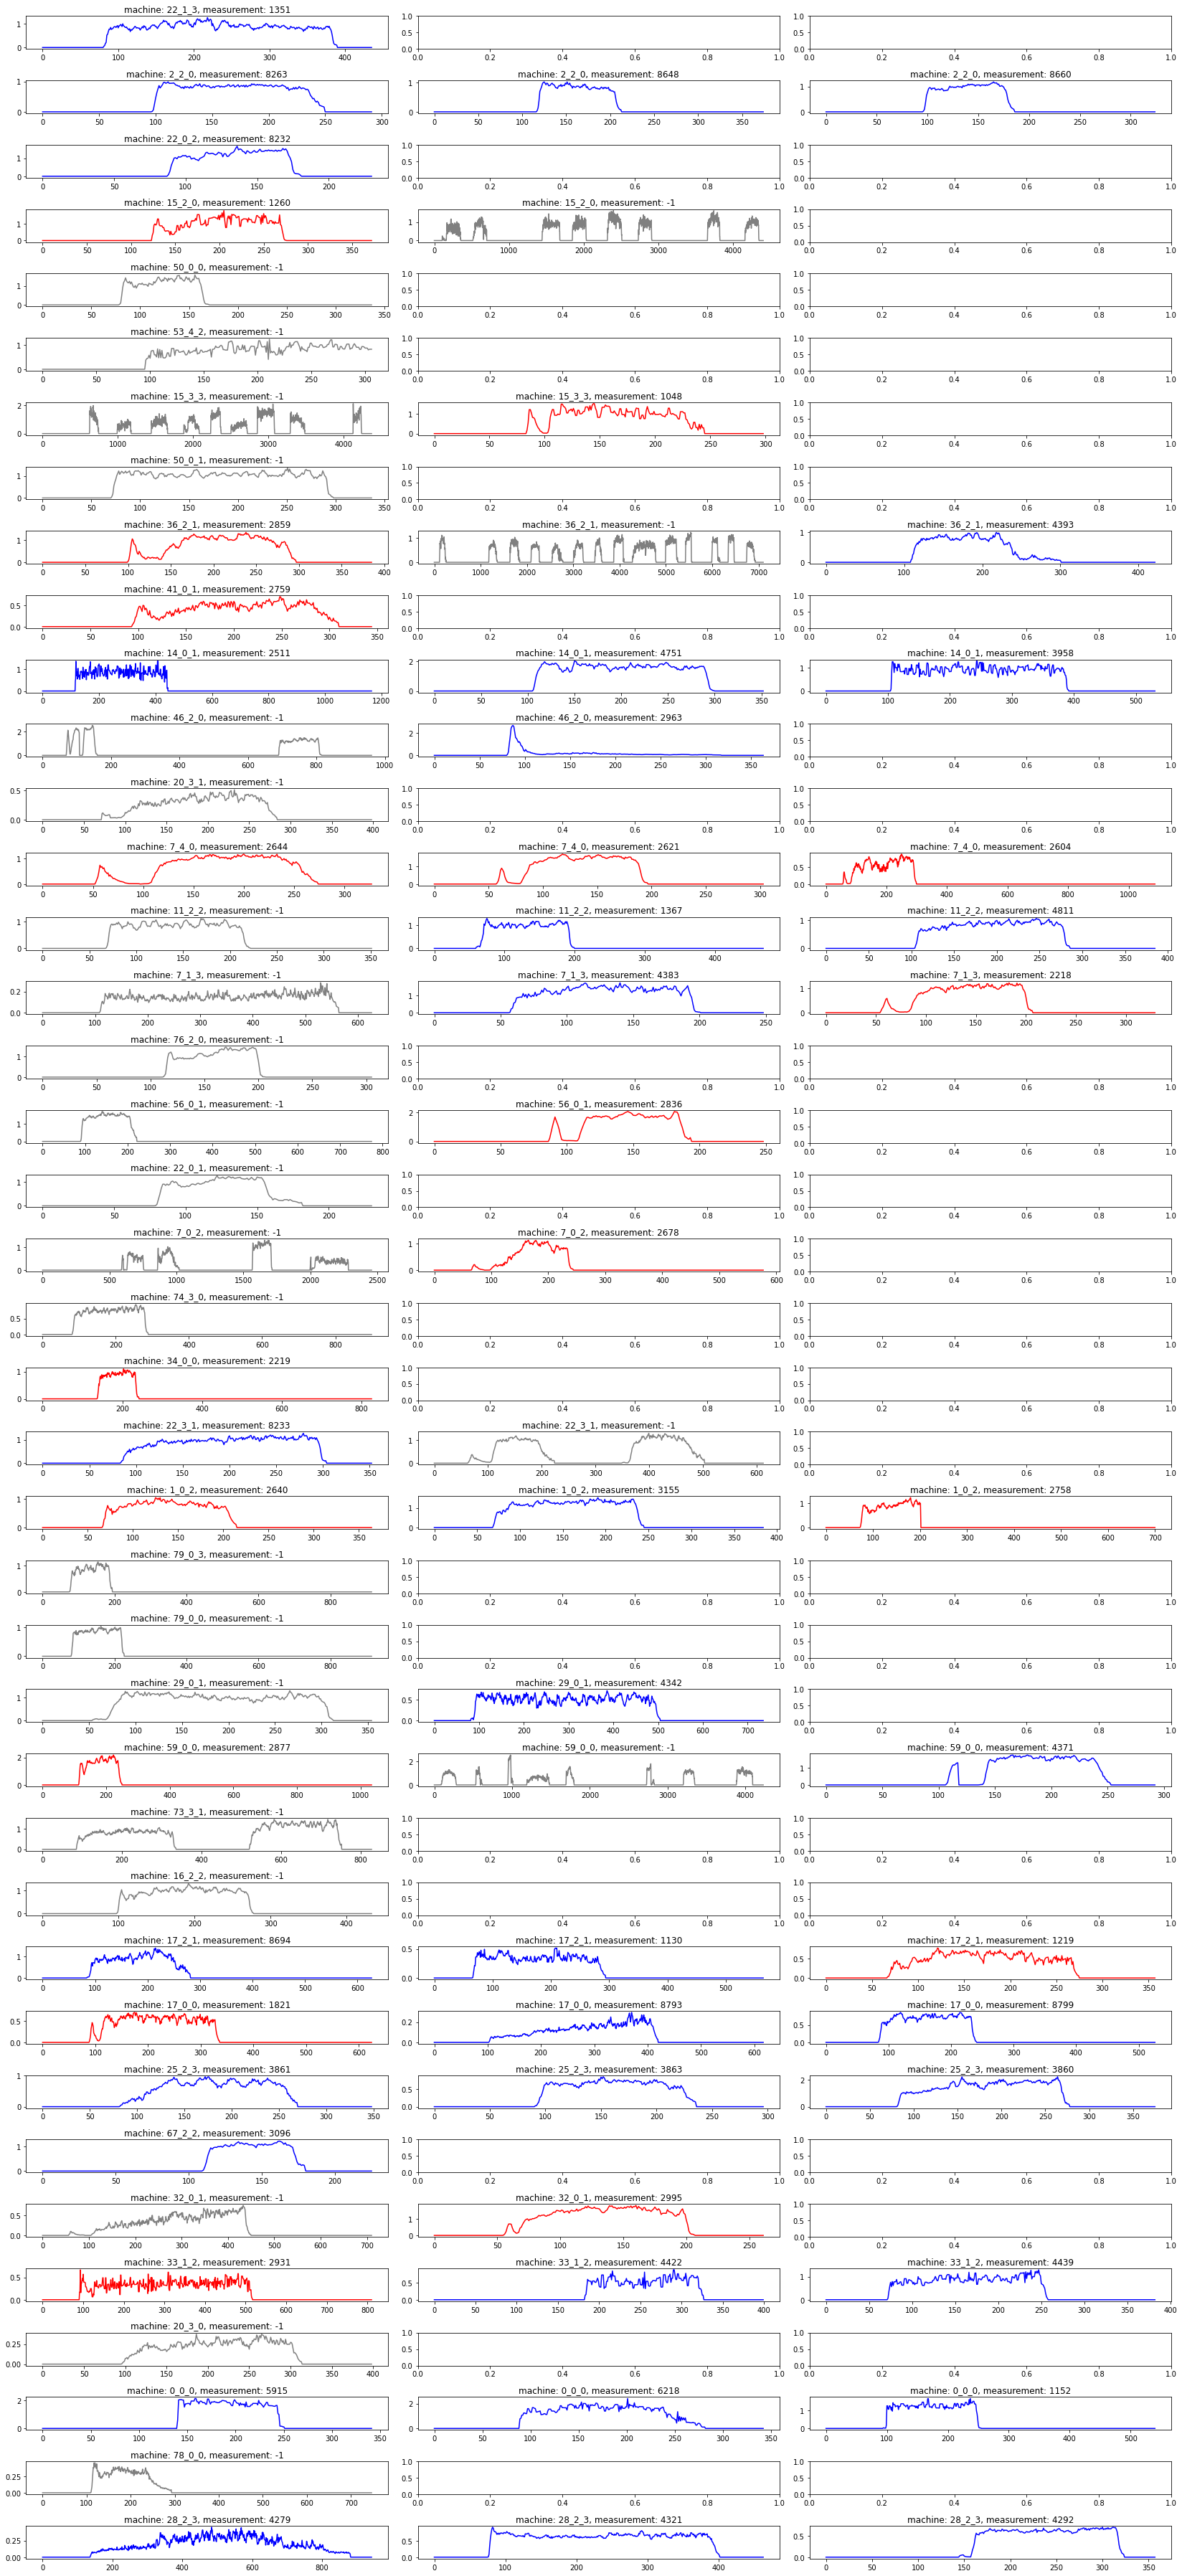

In [22]:
fig, charts = plt.subplots(nrows=40, ncols=3, figsize=(23,50))
pumpFailedColors = {True:'red',False:'blue','nan':'gray'}

for machidx, mach in enumerate(selected):
    for measidx, meas in enumerate(mach['measurements']):
        pumpFailed = labels[(labels['MachineId'] == mach['machine_id']) & (labels['MeasurementId'] == meas)]['PumpFailed']
        if len(pumpFailed) > 1:
            raise Exception('only one label of `PumpFailed` can be present for one measurement cycle')
        
        pumpFailed = pumpFailed.iloc[0] #select the only one label (if there is not only one, there is exception above)
        if math.isnan(pumpFailed):
            pumpFailed = 'nan'
        
        pressure = df[(df['MachineId'] == mach['machine_id']) & (df['MeasurementId'] == meas)]['Pressure']
        chart = charts[machidx][measidx]
        
        chart.plot(range(len(pressure)), pressure, color=pumpFailedColors[pumpFailed])
        chart.set_title(f"machine: {mach['machine_id']}, measurement: {meas}")

plt.tight_layout()  

Blue charts represents non-faulty cycles, while red represents faulty cycles. We can see that they can be somehow classified by eye, but not so clearly to use some direct heuristic.

# Ideas for preprocessing

If these charts are correct, then it's better to prefer modeling, as finding some heuristic rules would take lot of time. However, we can still use the knowledge from charts to determine some preprocessing of the data:

Due to time for this project, __we first try to use pressure measurement values directly as features__ with following types of preprocessing:

- we can crop cycles from leading or trailing zeros
- we can downsample / upsample to get same length of each cycle
  - we can resample each cycle into same number of chunks. That would put all cycles on same scale, however, its not sure whether this is good solution. Because it is possible that __real pump failrue has some absolute length__ (i.e absolute number of measurements, not relative to cycle length)
  - we can resample each cycle into different number of chunks, just given by number of samples in each chunk. This will keep ratio of each cycle, but means that scaling of individuals cycles is not standardized, and also we will need to pad or crop cycles, to make them having same length
- we can normalize pressure
  - we can normalize pressure per sample index (per columns / features, just as standard normalization), but that would distort relations between columns thus pressure relations within one cycle
  - we can normalize pressure accross one cycle (i.e. highest pressure during one cycle is equal to 1). Whether this makes sense, depends on whether we want to use information about absolute pressure in training process, or whether we want to use only information of relative pressure during cycle
  - we can normalize pressure accross all cycles of all machines (i.e. highest pressure in whole dataset is equal to 1, lowest to 0) - This can be useful if optimizing ML algorithm requires it, but currently from charts it seems that pressure is quite nice scaled from zero to one, so we won't do this now.
  - we can normalize pressure accross cycles from one machine (i.e. highest pressure from one machine is equal to 1) - We won't do this now due to time, only if we get only really bad results we may try it   
- Also it seems that measurements with Id -1 are not labeled, we will check it. If they are not labeled, we can't use them for training, so we will drop them. It also seems that -1 covers sometimes multiple cycles (which makes sense)

# Removing data without labels
From charts above, it seems that measure ids -1 have no labels usually. We will check it (across full dataset) and eventually drop these measurements

In [23]:
#check whether -1 are labeled
labels[labels['MeasurementId'] == -1]['PumpFailed'].unique()

array([nan], dtype=object)

All measurements with ID -1 are unlabeled. We can also check whether there are some other measurements IDs where pump failed is nan:

In [24]:
labels[labels['PumpFailed'].isnull()]['MeasurementId'].unique()

array([-1], dtype=int64)

so -1 measurements contains only nan, so we can drop -1 IDs from dataframe (also from labels, we can do that later). Also we can keep other IDs, as `nan` is only present for ID -1

In [25]:
temp_df = temp_df[temp_df['MeasurementId'] != -1]

in this case, we need to drop from selected measurements that are -1

In [26]:
selected_new = []
for item in selected:
    new_mes = []
    for mes in item['measurements']:
        if mes != -1:
            new_mes.append(mes)
    if len(new_mes) > 0:
        selected_new.append({'machine_id':item['machine_id'], 'measurements':new_mes})
selected_new

[{'machine_id': '22_1_3', 'measurements': [1351]},
 {'machine_id': '2_2_0', 'measurements': [8263, 8648, 8660]},
 {'machine_id': '22_0_2', 'measurements': [8232]},
 {'machine_id': '15_2_0', 'measurements': [1260]},
 {'machine_id': '15_3_3', 'measurements': [1048]},
 {'machine_id': '36_2_1', 'measurements': [2859, 4393]},
 {'machine_id': '41_0_1', 'measurements': [2759]},
 {'machine_id': '14_0_1', 'measurements': [2511, 4751, 3958]},
 {'machine_id': '46_2_0', 'measurements': [2963]},
 {'machine_id': '7_4_0', 'measurements': [2644, 2621, 2604]},
 {'machine_id': '11_2_2', 'measurements': [1367, 4811]},
 {'machine_id': '7_1_3', 'measurements': [4383, 2218]},
 {'machine_id': '56_0_1', 'measurements': [2836]},
 {'machine_id': '7_0_2', 'measurements': [2678]},
 {'machine_id': '34_0_0', 'measurements': [2219]},
 {'machine_id': '22_3_1', 'measurements': [8233]},
 {'machine_id': '1_0_2', 'measurements': [2640, 3155, 2758]},
 {'machine_id': '29_0_1', 'measurements': [4342]},
 {'machine_id': '59_0

# Convert individual measurements to wide
Now we will convert individual measurements to wide table, so that one row contains full cycle as that will be useful for following operations

In [27]:
temp_df_grouped = temp_df.groupby(['MachineId','MeasurementId']).agg({'Pressure':lambda x: list(x)}).reset_index()
temp_df_grouped

MachineId  MeasurementId  \
0        0_0_0              0   
1        0_0_0            215   
2        0_0_0            237   
3        0_0_0            353   
4        0_0_0            411   
...        ...            ...   
1225     7_4_0           2612   
1226     7_4_0           2621   
1227     7_4_0           2644   
1228     7_4_0           2710   
1229     7_4_0           2753   

                                               Pressure  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
1225  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1226  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1227  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1228  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1229  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[1230 rows x 3 columns]

# Prepare method to plot sample charts for wide table

show method for cases where there are all measurement in one column. This is usable for dataset where measurements are converted to wide already

In [28]:
def show_charts(df=temp_df_grouped, labels=labels, selected=selected_new, pressure_col='Pressure'):
    """
    just to be able to show charts quickly
    """
    fig, charts = plt.subplots(nrows=len(selected), ncols=3, figsize=(23,2*len(selected)))
    pumpFailedColors = {True:'red',False:'blue','nan':'gray'}

    for machidx, mach in enumerate(selected):
        for measidx, meas in enumerate(mach['measurements']):
            pumpFailed = labels[(labels['MachineId'] == mach['machine_id']) & (labels['MeasurementId'] == meas)]['PumpFailed']
            if len(pumpFailed) > 1:
                raise Exception('only one label of `PumpFailed` can be present for one measurement cycle')

            pumpFailed = pumpFailed.iloc[0] #select the only one label (if there is not only one, there is exception above)
            if math.isnan(pumpFailed):
                pumpFailed = 'nan'

            pressure = df[(df['MachineId'] == mach['machine_id']) & (df['MeasurementId'] == meas)][pressure_col].iloc[0] #this is the difference from previous charts (zero index) = get only first value, as it's whole vector already
            chart = charts[machidx][measidx]

            chart.plot(range(len(pressure)), pressure, color=pumpFailedColors[pumpFailed])
            chart.set_title(f"machine: {mach['machine_id']}, measurement: {meas}")

    plt.tight_layout()

# Cropping cycles from zeros
This method will remove starting and trailing zeros

In [29]:
def remove_values_lr(data, value=0):
    """
    crops from values from left and right, meant to be used for zeros
    """
    output, left, right = [], 0, len(data)-1
    leftset, rightset = False, False
    for idx in range(len(data)):
        if data[idx] != value and leftset is False:
            left = idx
            leftset = True
        if data[(-idx)-1] != value and rightset is False:
            right = (len(data)-1)-idx
            rightset = True
        if leftset and rightset:
            return data[left-1:right+1] #let's keep first and last zero (found in charts later)

crop

In [30]:
temp_df_grouped['Pressure'] = temp_df_grouped['Pressure'].apply(lambda x: remove_values_lr(x,0))
temp_df_grouped = temp_df_grouped[temp_df_grouped['Pressure'].apply(lambda x: str(x) != 'None')] #i found there are some measurements with all zeros, this must be dropped. When I checked it, it was small portion only
temp_df_grouped

MachineId  MeasurementId  \
0        0_0_0              0   
1        0_0_0            215   
2        0_0_0            237   
3        0_0_0            353   
4        0_0_0            411   
...        ...            ...   
1225     7_4_0           2612   
1226     7_4_0           2621   
1227     7_4_0           2644   
1228     7_4_0           2710   
1229     7_4_0           2753   

                                               Pressure  
0     [0.0, 0.43980582524271844, 1.0223300970873785,...  
1     [0.0, 0.34017595307917886, 0.4173998044965787,...  
2     [0.0, 1.0817669172932332, 1.0817669172932332, ...  
3     [0.0, 0.23129251700680273, 0.6209912536443148,...  
4     [0.0, 0.15188470066518847, 0.5997782705099778,...  
...                                                 ...  
1225  [0.0, 0.024485798237022526, 0.0509304603330068...  
1226  [0.0, 0.07292817679558011, 0.19337016574585636...  
1227  [0.0, 0.08412197686645637, 0.19032597266035753...  
1228  [0.0, 0.026522593320235755, 0.2190569744597249...  
1229  [0.0, 0.1187363834422658, 0.3202614379084967, ...  

[1228 rows x 3 columns]

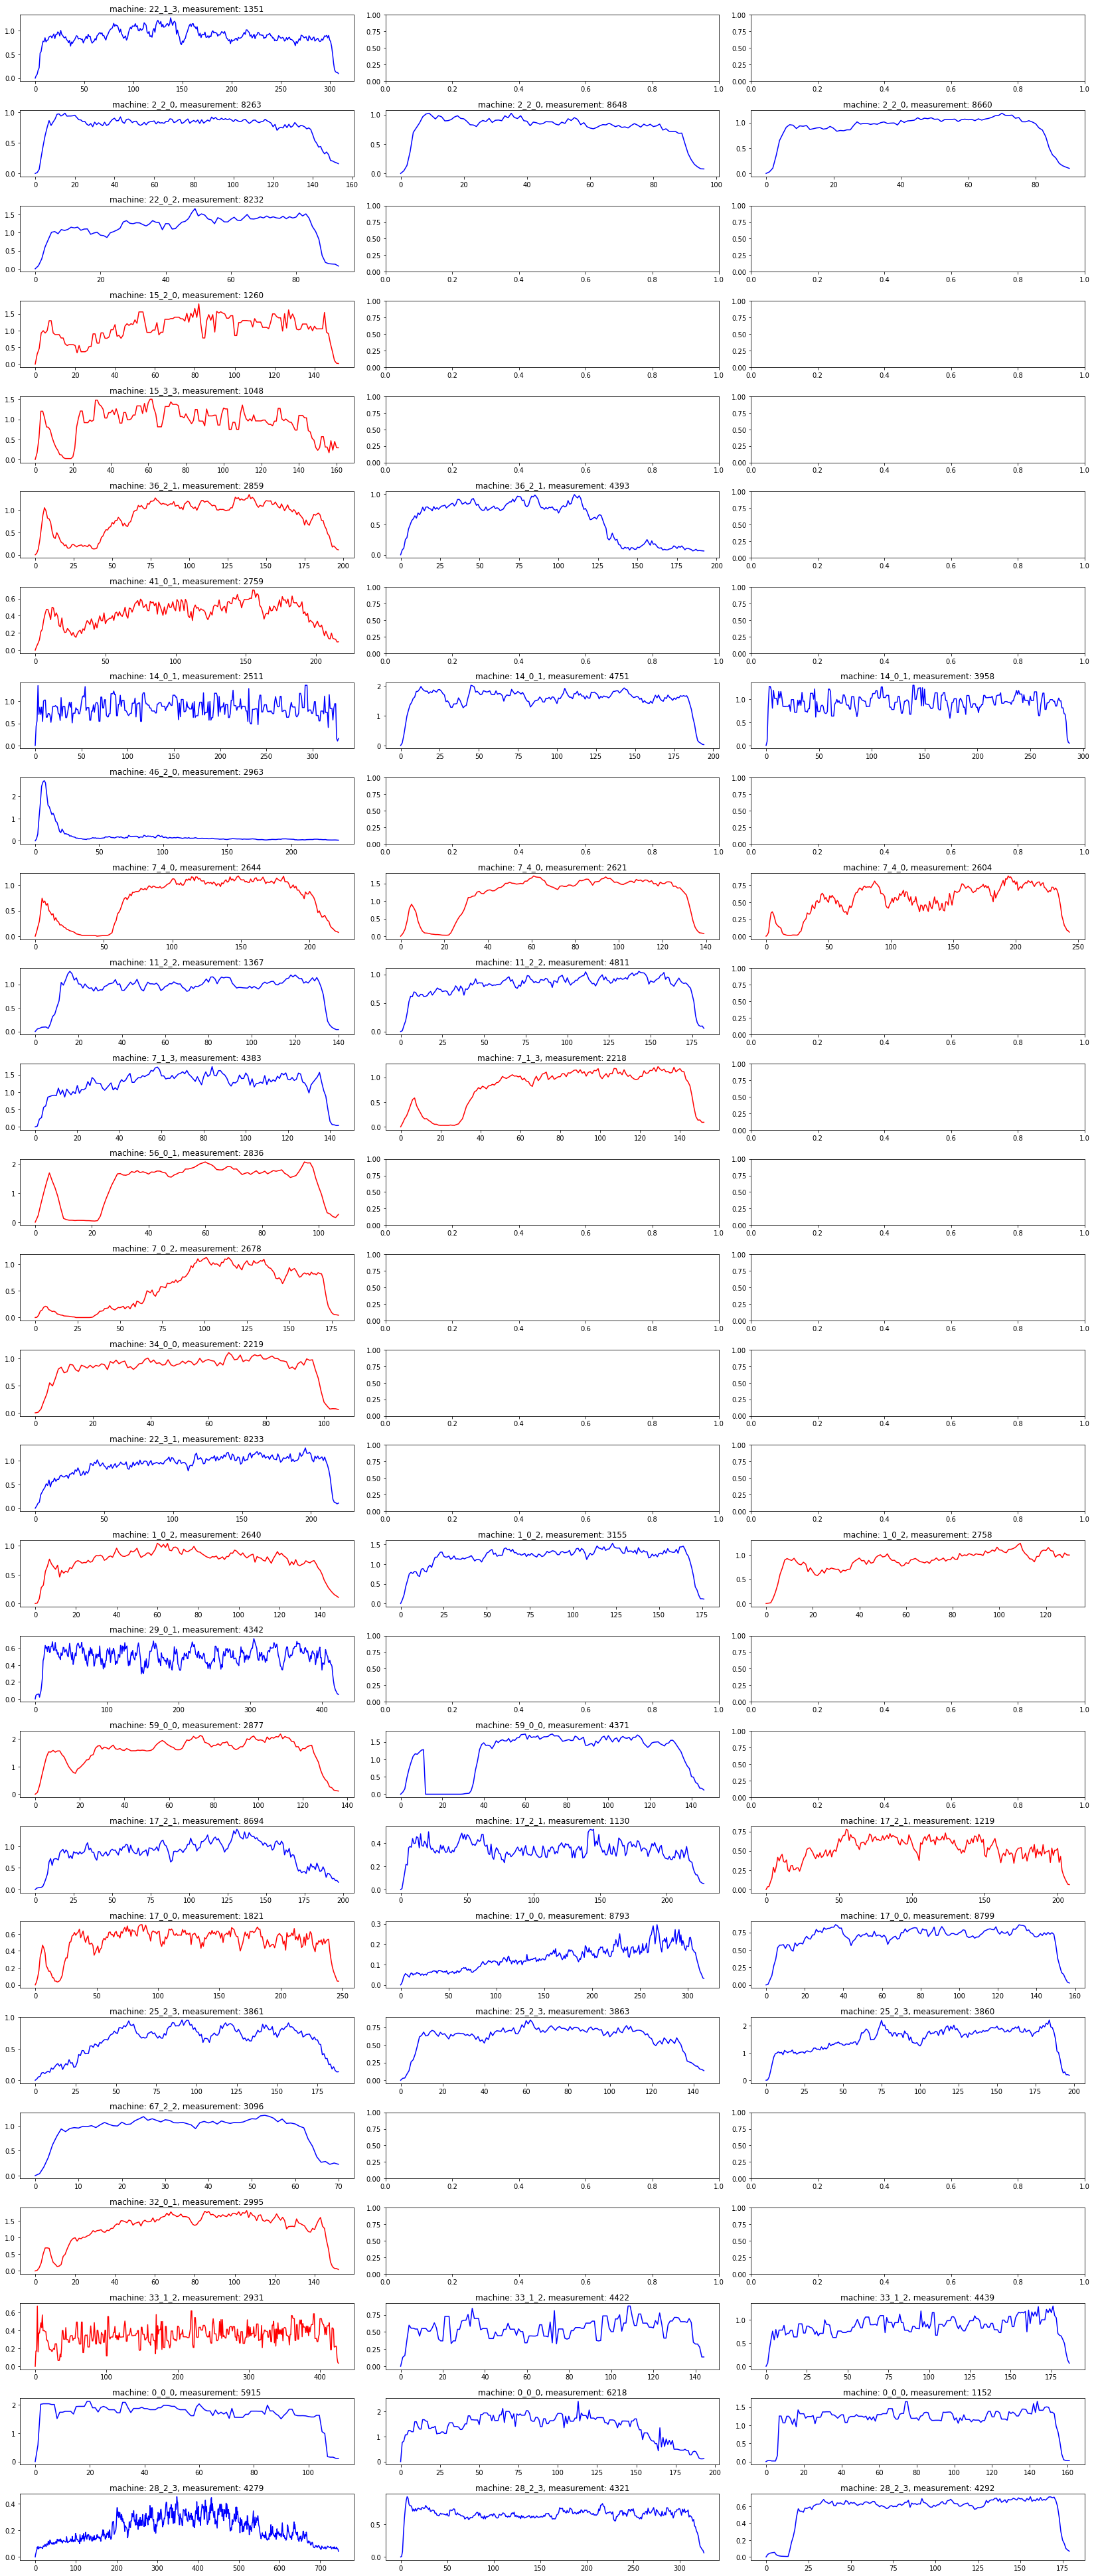

In [31]:
show_charts(df=temp_df_grouped)

by taking quick look on chart above (with cropped data) and previous chart (uncropped data), it seems that crop method works correctly

# Downsample or upsample data
Now I will downsample or upsample the data. I will try two approaches, one that normalizes all lengths to be same, and another one that just reduces resolution, but keeps ratios (is padded with zeros or cropped to get same length). The reason for second one, is that it may provide different predictive power, as it is possible, that _pump failure_ event has similar length in reality, even in when cycles have different length. Because of this, the first approach could distort features.

In [32]:
def upsample_into_n_points(data, n_samples=100):
    """
    linear interpolation
    """
    output = []
    for idx in range(len(data)):
        current_chunk_idx = floor((idx/len(data))*n_samples)
        next_chunk_idx = floor(((idx+1)/len(data))*n_samples)
        diff = next_chunk_idx-current_chunk_idx
        current_sample = data[idx]
        next_sample = current_sample
        if len(data) > idx+1:
            next_sample = data[idx+1]
        interpolation = [(next_sample-current_sample)*(i/(diff))+current_sample for i in range(diff)]
        output.extend(interpolation)
        
    return output


In [33]:
def downsample_into_n_points(data, n_samples=100, group_size=None, agg=np.median):
    """
    when using n_samples: normalizes data into n samples with custom callable. This can stretch the data, so its not recommended when we need same scale
    
    when using group_size: normalizes data into n samples with custom callable. The number of n samples is determined by data length divided by group size.
    That means that if running this on multiple data, it will always provide same scaled result, but with different length
    """
    templist, previous_chunk, output = [], 0, []
    for idx, sample in enumerate(data):
        
        if n_samples is not None and group_size is not None:
            raise Exception('only one of `n_samples`, `group_size` can be used as these are exclusive types of sampling')
        
        if n_samples is not None:
            chunk_idx = floor((idx/len(data))*n_samples)
        elif group_size is not None:
            chunk_idx = floor(idx/group_size)
        
        if chunk_idx == previous_chunk:
            templist.append(sample)
        else:   
            output.append(agg(templist))
            templist, previous_chunk = [], chunk_idx
            templist.append(sample)
            
        if idx == len(data)-1:
            output.append(agg(templist))
            
    return output

In [34]:
def downsample_or_upsample(data, n_samples=100, agg=np.median): #group size not used as that is clearly downsampling
    if len(data) == n_samples:
        return data
    elif len(data) > n_samples:
        return downsample_into_n_points(data, n_samples, None, agg)
    else:
        return upsample_into_n_points(data, n_samples)

### First approach - downsample or upsample and normalize length by stretching

In [35]:
temp_df_grouped['Pressure_stretch'] = temp_df_grouped['Pressure'].apply(lambda x: downsample_or_upsample(x,100))
temp_df_grouped

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\2296805231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_stretch'] = temp_df_grouped['Pressure'].apply(lambda x: downsample_or_upsample(x,100))


MachineId  MeasurementId  \
0        0_0_0              0   
1        0_0_0            215   
2        0_0_0            237   
3        0_0_0            353   
4        0_0_0            411   
...        ...            ...   
1225     7_4_0           2612   
1226     7_4_0           2621   
1227     7_4_0           2644   
1228     7_4_0           2710   
1229     7_4_0           2753   

                                               Pressure  \
0     [0.0, 0.43980582524271844, 1.0223300970873785,...   
1     [0.0, 0.34017595307917886, 0.4173998044965787,...   
2     [0.0, 1.0817669172932332, 1.0817669172932332, ...   
3     [0.0, 0.23129251700680273, 0.6209912536443148,...   
4     [0.0, 0.15188470066518847, 0.5997782705099778,...   
...                                                 ...   
1225  [0.0, 0.024485798237022526, 0.0509304603330068...   
1226  [0.0, 0.07292817679558011, 0.19337016574585636...   
1227  [0.0, 0.08412197686645637, 0.19032597266035753...   
1228  [0.0, 0.026522593320235755, 0.2190569744597249...   
1229  [0.0, 0.1187363834422658, 0.3202614379084967, ...   

                                       Pressure_stretch  
0     [0.21990291262135922, 1.0223300970873785, 1.16...  
1     [0.17008797653958943, 0.4731182795698925, 0.52...  
2     [1.0817669172932332, 1.0963345864661656, 1.225...  
3     [0.23129251700680273, 0.6929057337220602, 0.75...  
4     [0.07594235033259424, 0.5997782705099778, 0.22...  
...                                                 ...  
1225  [0.03770812928501469, 0.06758080313418217, 0.0...  
1226  [0.036464088397790057, 0.19337016574585636, 0....  
1227  [0.08412197686645637, 0.39274447949526814, 0.7...  
1228  [0.013261296660117878, 0.21905697445972494, 0....  
1229  [0.0593681917211329, 0.6644880174291938, 1.100...  

[1228 rows x 4 columns]

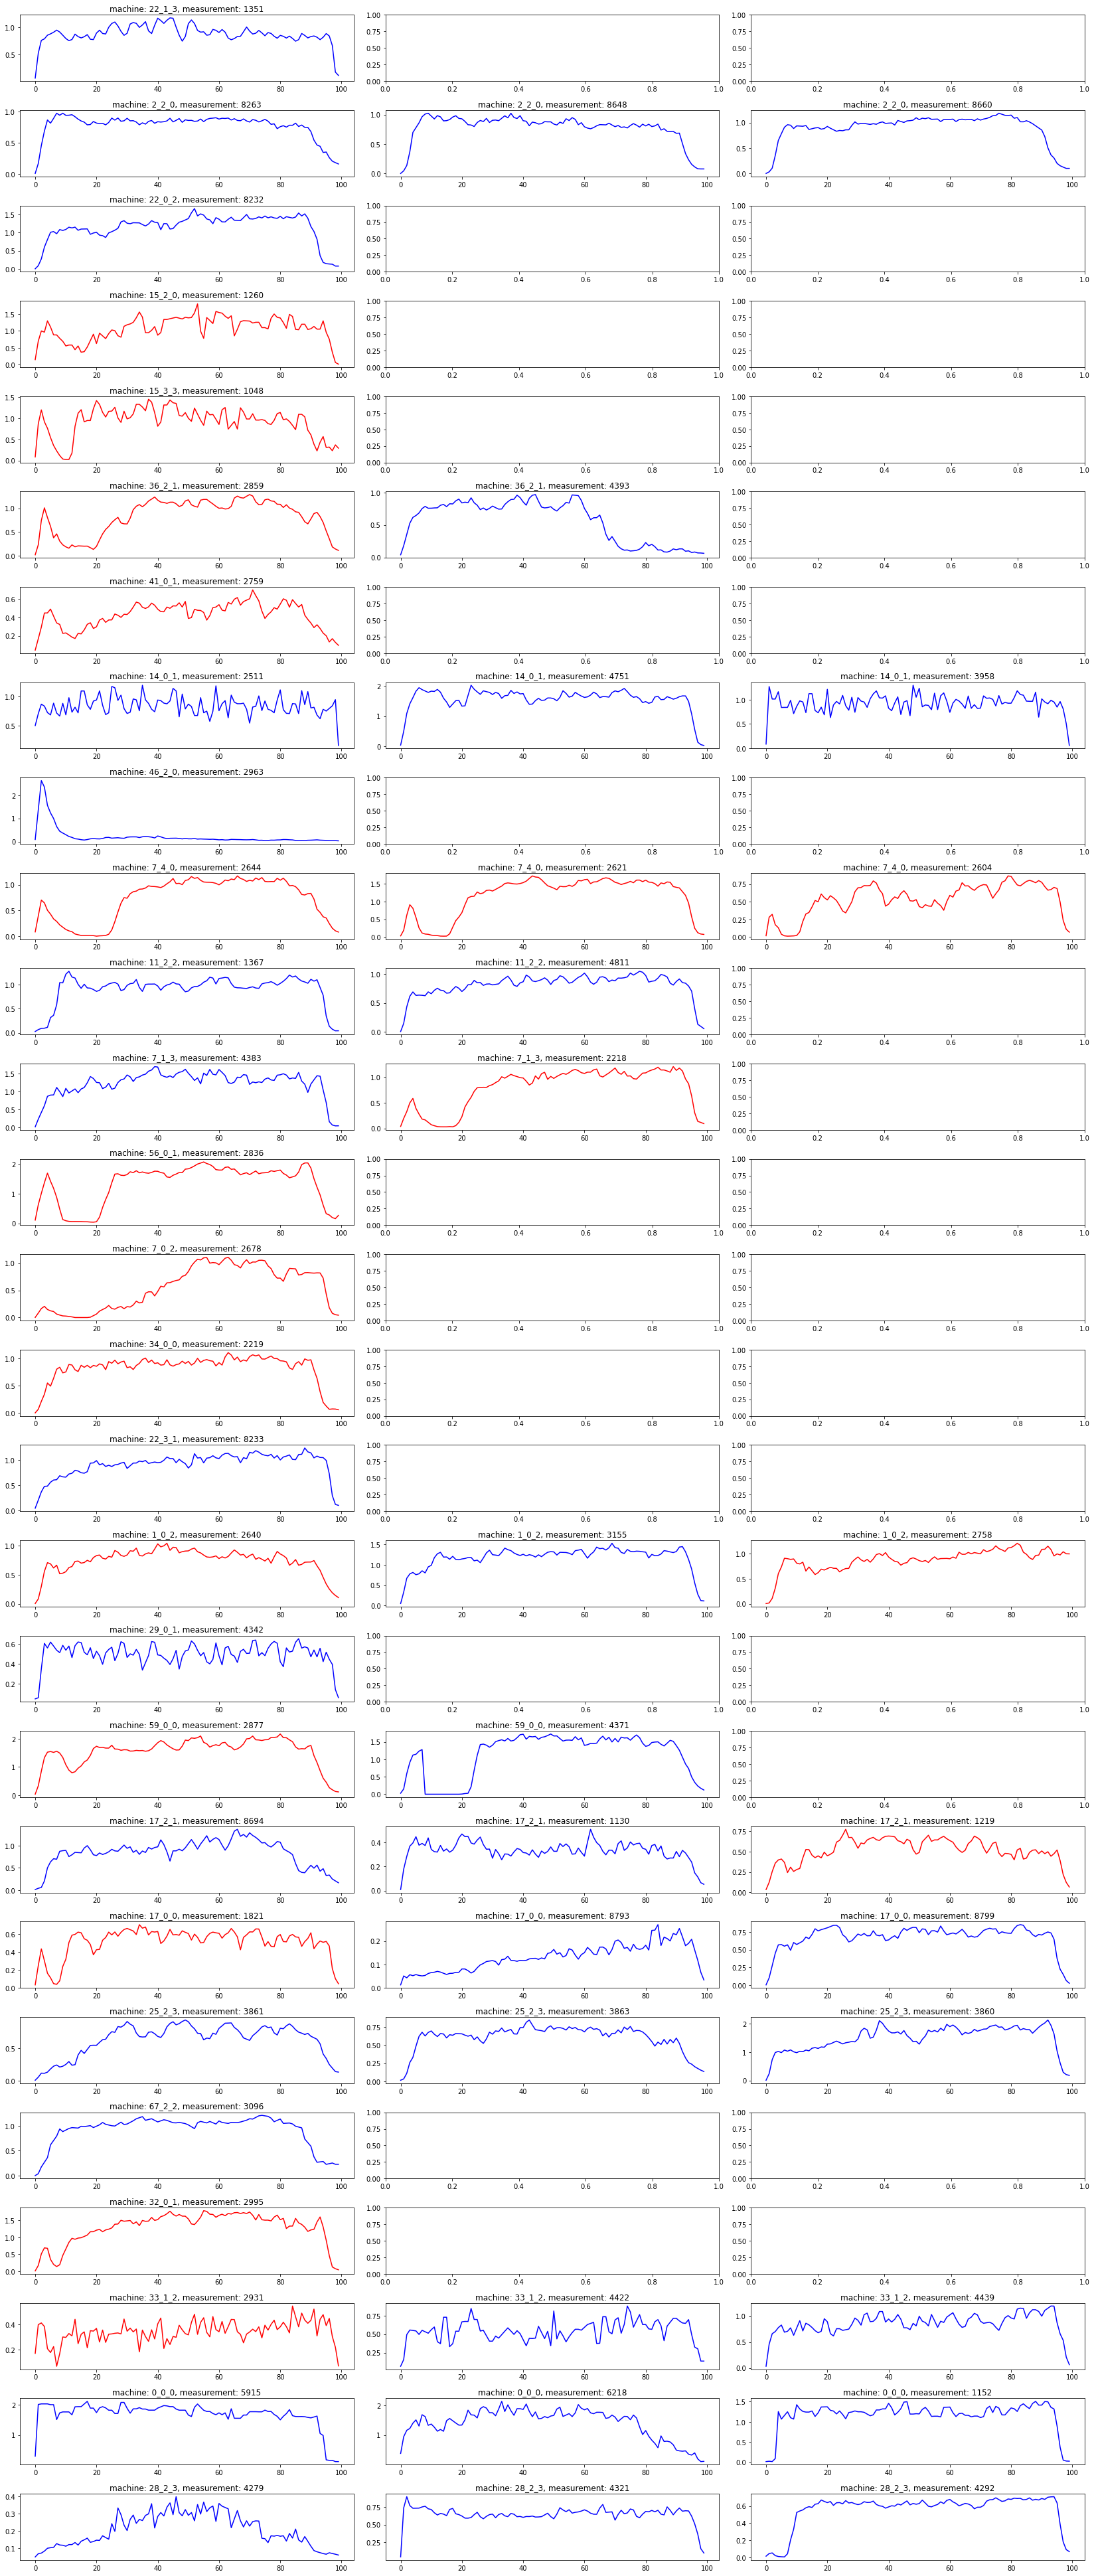

In [36]:
show_charts(df=temp_df_grouped, pressure_col='Pressure_stretch')

when we take a look at this charts and compare with previous, we can see that both downsampling and upsampling is working

### Resolution reduce - approach 2
In this approach we only downsample and we keep absolute length to be original, so that when cycles are compared, their ratio is unchanged. To get same length of all cycles we do padding or cropping (the number of measuremnets is taken by taking a look at original charts and standard length of cycles)

In [37]:
def rpad(data,total_length,value=0):
    if len(data) > total_length:
        return data[:total_length]
    return data+[value for _ in range(total_length-len(data))]

In [38]:
temp_df_grouped['Pressure_downscale'] = temp_df_grouped['Pressure'].apply(lambda x: downsample_into_n_points(x, n_samples=None, group_size=5))
temp_df_grouped['Pressure_downscale'] = temp_df_grouped['Pressure_downscale'].apply(lambda x: [0]+rpad(x, total_length=70))
temp_df_grouped

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3835497298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_downscale'] = temp_df_grouped['Pressure'].apply(lambda x: downsample_into_n_points(x, n_samples=None, group_size=5))
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3835497298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_downscale'] = temp_df_grouped['Pressure_downscale'].apply(lambda x: [0]+rpad(x, total_length=70))


MachineId  MeasurementId  \
0        0_0_0              0   
1        0_0_0            215   
2        0_0_0            237   
3        0_0_0            353   
4        0_0_0            411   
...        ...            ...   
1225     7_4_0           2612   
1226     7_4_0           2621   
1227     7_4_0           2644   
1228     7_4_0           2710   
1229     7_4_0           2753   

                                               Pressure  \
0     [0.0, 0.43980582524271844, 1.0223300970873785,...   
1     [0.0, 0.34017595307917886, 0.4173998044965787,...   
2     [0.0, 1.0817669172932332, 1.0817669172932332, ...   
3     [0.0, 0.23129251700680273, 0.6209912536443148,...   
4     [0.0, 0.15188470066518847, 0.5997782705099778,...   
...                                                 ...   
1225  [0.0, 0.024485798237022526, 0.0509304603330068...   
1226  [0.0, 0.07292817679558011, 0.19337016574585636...   
1227  [0.0, 0.08412197686645637, 0.19032597266035753...   
1228  [0.0, 0.026522593320235755, 0.2190569744597249...   
1229  [0.0, 0.1187363834422658, 0.3202614379084967, ...   

                                       Pressure_stretch  \
0     [0.21990291262135922, 1.0223300970873785, 1.16...   
1     [0.17008797653958943, 0.4731182795698925, 0.52...   
2     [1.0817669172932332, 1.0963345864661656, 1.225...   
3     [0.23129251700680273, 0.6929057337220602, 0.75...   
4     [0.07594235033259424, 0.5997782705099778, 0.22...   
...                                                 ...   
1225  [0.03770812928501469, 0.06758080313418217, 0.0...   
1226  [0.036464088397790057, 0.19337016574585636, 0....   
1227  [0.08412197686645637, 0.39274447949526814, 0.7...   
1228  [0.013261296660117878, 0.21905697445972494, 0....   
1229  [0.0593681917211329, 0.6644880174291938, 1.100...   

                                     Pressure_downscale  
0     [0, 0.9233009708737864, 0.929126213592233, 0.9...  
1     [0, 0.4173998044965787, 1.206256109481916, 1.1...  
2     [0, 1.0817669172932332, 1.2744360902255638, 1....  
3     [0, 0.6209912536443148, 0.6501457725947521, 0....  
4     [0, 0.22283813747228381, 0.22283813747228381, ...  
...                                                 ...  
1225  [0, 0.050930460333006855, 0.059745347698334964...  
1226  [0, 0.19337016574585636, 0.6850828729281768, 0...  
1227  [0, 0.19032597266035753, 0.6603575184016824, 0...  
1228  [0, 0.21905697445972494, 0.7426326129666012, 0...  
1229  [0, 0.3202614379084967, 0.7919389978213508, 0....  

[1228 rows x 5 columns]

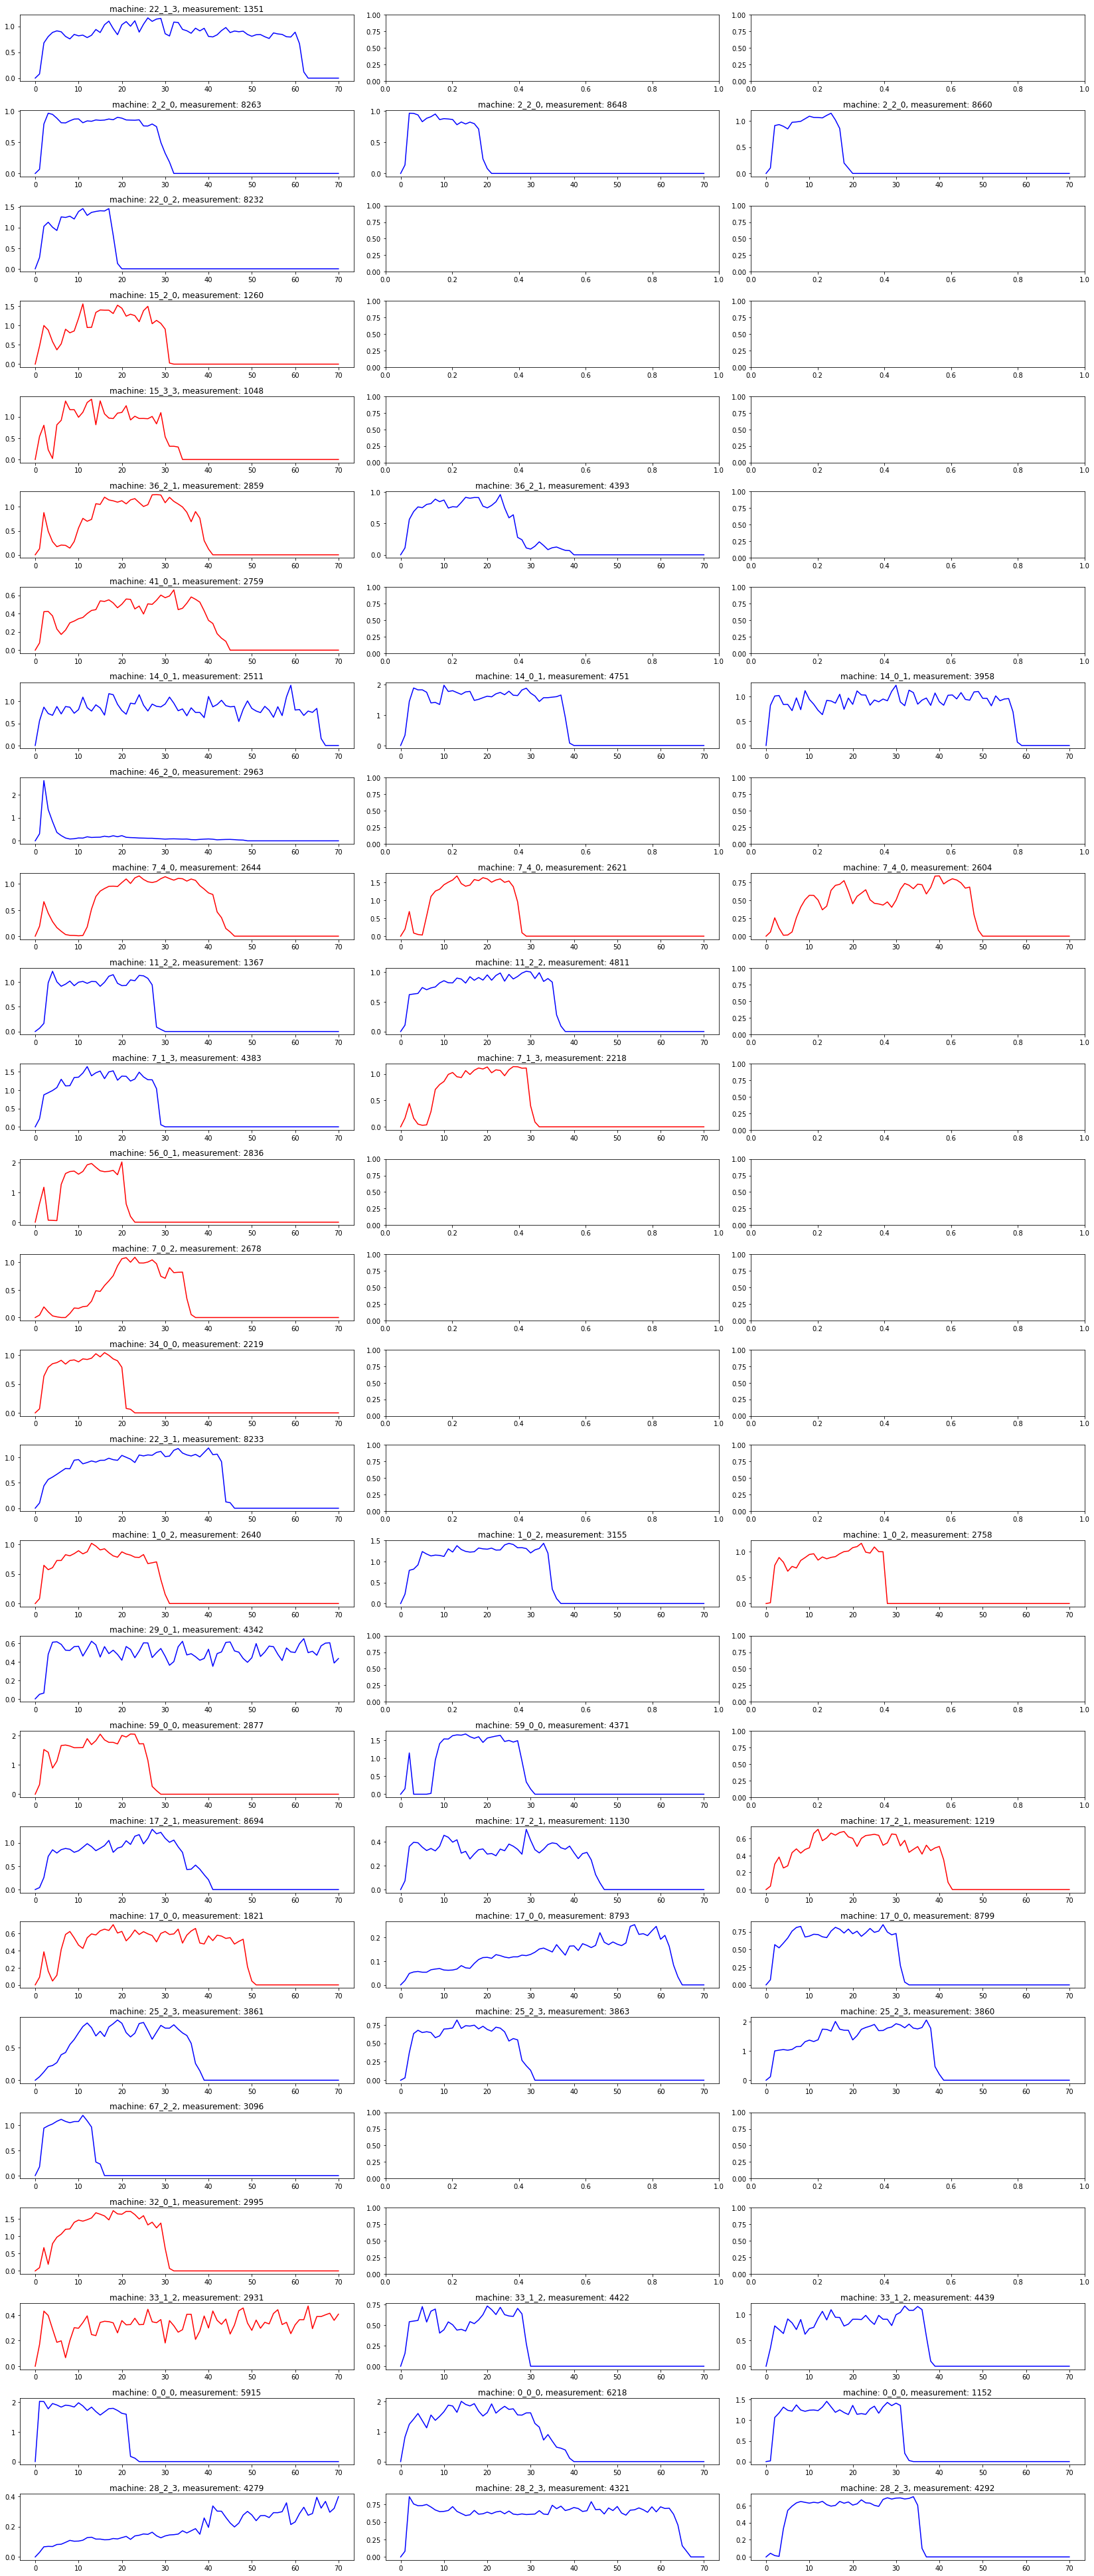

In [39]:
show_charts(df=temp_df_grouped,pressure_col='Pressure_downscale')

this seems to be correct. Some charts are cropped, but most of them not, if we had more time, it would be nice to do some analysis to set proper length of cycle

# Normalize data
In this part, we normalize pressure values

## Normalize data within each cycle
Normalization within row (cycle) - so individual features are relative to values of other features on same row.

In [40]:
from sklearn.preprocessing import minmax_scale
temp_df_grouped['Pressure_downscale_norm'] = temp_df_grouped['Pressure_downscale'].apply(lambda x: minmax_scale(x))
temp_df_grouped['Pressure_stretch_norm'] = temp_df_grouped['Pressure_stretch'].apply(lambda x: minmax_scale(x))
temp_df_grouped

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\2667420211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_downscale_norm'] = temp_df_grouped['Pressure_downscale'].apply(lambda x: minmax_scale(x))
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\2667420211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_stretch_norm'] = temp_df_grouped['Pressure_stretch'].apply(lambda x: minmax_scale(x))


MachineId  MeasurementId  \
0        0_0_0              0   
1        0_0_0            215   
2        0_0_0            237   
3        0_0_0            353   
4        0_0_0            411   
...        ...            ...   
1225     7_4_0           2612   
1226     7_4_0           2621   
1227     7_4_0           2644   
1228     7_4_0           2710   
1229     7_4_0           2753   

                                               Pressure  \
0     [0.0, 0.43980582524271844, 1.0223300970873785,...   
1     [0.0, 0.34017595307917886, 0.4173998044965787,...   
2     [0.0, 1.0817669172932332, 1.0817669172932332, ...   
3     [0.0, 0.23129251700680273, 0.6209912536443148,...   
4     [0.0, 0.15188470066518847, 0.5997782705099778,...   
...                                                 ...   
1225  [0.0, 0.024485798237022526, 0.0509304603330068...   
1226  [0.0, 0.07292817679558011, 0.19337016574585636...   
1227  [0.0, 0.08412197686645637, 0.19032597266035753...   
1228  [0.0, 0.026522593320235755, 0.2190569744597249...   
1229  [0.0, 0.1187363834422658, 0.3202614379084967, ...   

                                       Pressure_stretch  \
0     [0.21990291262135922, 1.0223300970873785, 1.16...   
1     [0.17008797653958943, 0.4731182795698925, 0.52...   
2     [1.0817669172932332, 1.0963345864661656, 1.225...   
3     [0.23129251700680273, 0.6929057337220602, 0.75...   
4     [0.07594235033259424, 0.5997782705099778, 0.22...   
...                                                 ...   
1225  [0.03770812928501469, 0.06758080313418217, 0.0...   
1226  [0.036464088397790057, 0.19337016574585636, 0....   
1227  [0.08412197686645637, 0.39274447949526814, 0.7...   
1228  [0.013261296660117878, 0.21905697445972494, 0....   
1229  [0.0593681917211329, 0.6644880174291938, 1.100...   

                                     Pressure_downscale  \
0     [0, 0.9233009708737864, 0.929126213592233, 0.9...   
1     [0, 0.4173998044965787, 1.206256109481916, 1.1...   
2     [0, 1.0817669172932332, 1.2744360902255638, 1....   
3     [0, 0.6209912536443148, 0.6501457725947521, 0....   
4     [0, 0.22283813747228381, 0.22283813747228381, ...   
...                                                 ...   
1225  [0, 0.050930460333006855, 0.059745347698334964...   
1226  [0, 0.19337016574585636, 0.6850828729281768, 0...   
1227  [0, 0.19032597266035753, 0.6603575184016824, 0...   
1228  [0, 0.21905697445972494, 0.7426326129666012, 0...   
1229  [0, 0.3202614379084967, 0.7919389978213508, 0....   

                                Pressure_downscale_norm  \
0     [0.0, 0.7075892857142856, 0.7120535714285714, ...   
1     [0.0, 0.24710648148148148, 0.7141203703703703,...   
2     [0.0, 0.6238482384823849, 0.7349593495934958, ...   
3     [0.0, 0.6364541832669323, 0.6663346613545816, ...   
4     [0.0, 0.12578222778473092, 0.12578222778473092...   
...                                                 ...   
1225  [0.0, 0.05990783410138248, 0.07027649769585252...   
1226  [0.0, 0.1154353562005277, 0.40897097625329815,...   
1227  [0.0, 0.16514598540145986, 0.572992700729927, ...   
1228  [0.0, 0.1252808988764045, 0.42471910112359557,...   
1229  [0.0, 0.20068259385665527, 0.4962457337883959,...   

                                  Pressure_stretch_norm  
0     [0.10420650095602296, 0.6309751434034417, 0.72...  
1     [0.0, 0.19546027742749056, 0.2313997477931904,...  
2     [0.5905091975473208, 0.5987736603572381, 0.672...  
3     [0.14817749603803487, 0.5245641838351822, 0.57...  
4     [0.0, 0.28854961832061066, 0.08091603053435115...  
...                                                 ...  
1225  [0.018644067796610174, 0.053107344632768366, 0...  
1226  [0.005245901639344262, 0.09836065573770492, 0....  
1227  [0.07062528115159696, 0.33468286099865047, 0.5...  
1228  [0.0, 0.11597010794353722, 0.40963188486022695...  
1229  [0.018125854993160058, 0.39808481532147744, 0....  

[1228 rows x 7 columns]

## Normalize data within columns
Normalization of values within individual features. This can distort relations of pressures within individual cycles, on the other hand, scales each feature on one scale. We will later try whether it's working or not.

In [41]:
#everything in one row without any explanation is nightmare, better to make it as func
#temp_df_grouped['Pressure_downscale_norm_cols'] = list(map(lambda x: list(x), np.array(list(map(lambda x: minmax_scale(x),np.array(temp_df_grouped['Pressure_downscale'].to_list()).transpose()))).transpose()))

def normalize_over_columns(df, pressure_col):
    """
    normalization over columns. In case of machine cycles it actually distorts data a lot, so it's not sure whether this can be working. However, some logistic regression solvers works better
    with normalization over columns. Don't use this for classifiers methods that considers feature interactions (charts will be self-explanatory)
    """
    as_array = np.array(df[pressure_col].to_list()) #row = cycle, column = pressure value (feature)
    as_array_T = as_array.transpose() #row = pressure value (feature), column = cycle
    as_array_T_scaled = np.array(list(map(lambda x: minmax_scale(x), as_array_T))) #row = pressure value (feature) normalized to 0-1, column = cycle
    as_array_scaled = as_array_T_scaled.transpose() #row = cycle, column = pressure value (feature) normalized
    
    #need to be converted to list, because if np.array, pandas cannot set it into single column
    as_list = list(map(lambda x: list(x), as_array_scaled)) #row = cycle, column = pressure value (feature) normalized #all is in list format, so that it can be put into single pandas column
    
    return as_list  

In [42]:
temp_df_grouped['Pressure_downscale_norm_cols'] = normalize_over_columns(temp_df_grouped, 'Pressure_downscale')
temp_df_grouped['Pressure_stretch_norm_cols'] = normalize_over_columns(temp_df_grouped, 'Pressure_stretch')

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\1003766621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_downscale_norm_cols'] = normalize_over_columns(temp_df_grouped, 'Pressure_downscale')
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\1003766621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df_grouped['Pressure_stretch_norm_cols'] = normalize_over_columns(temp_df_grouped, 'Pressure_stretch')


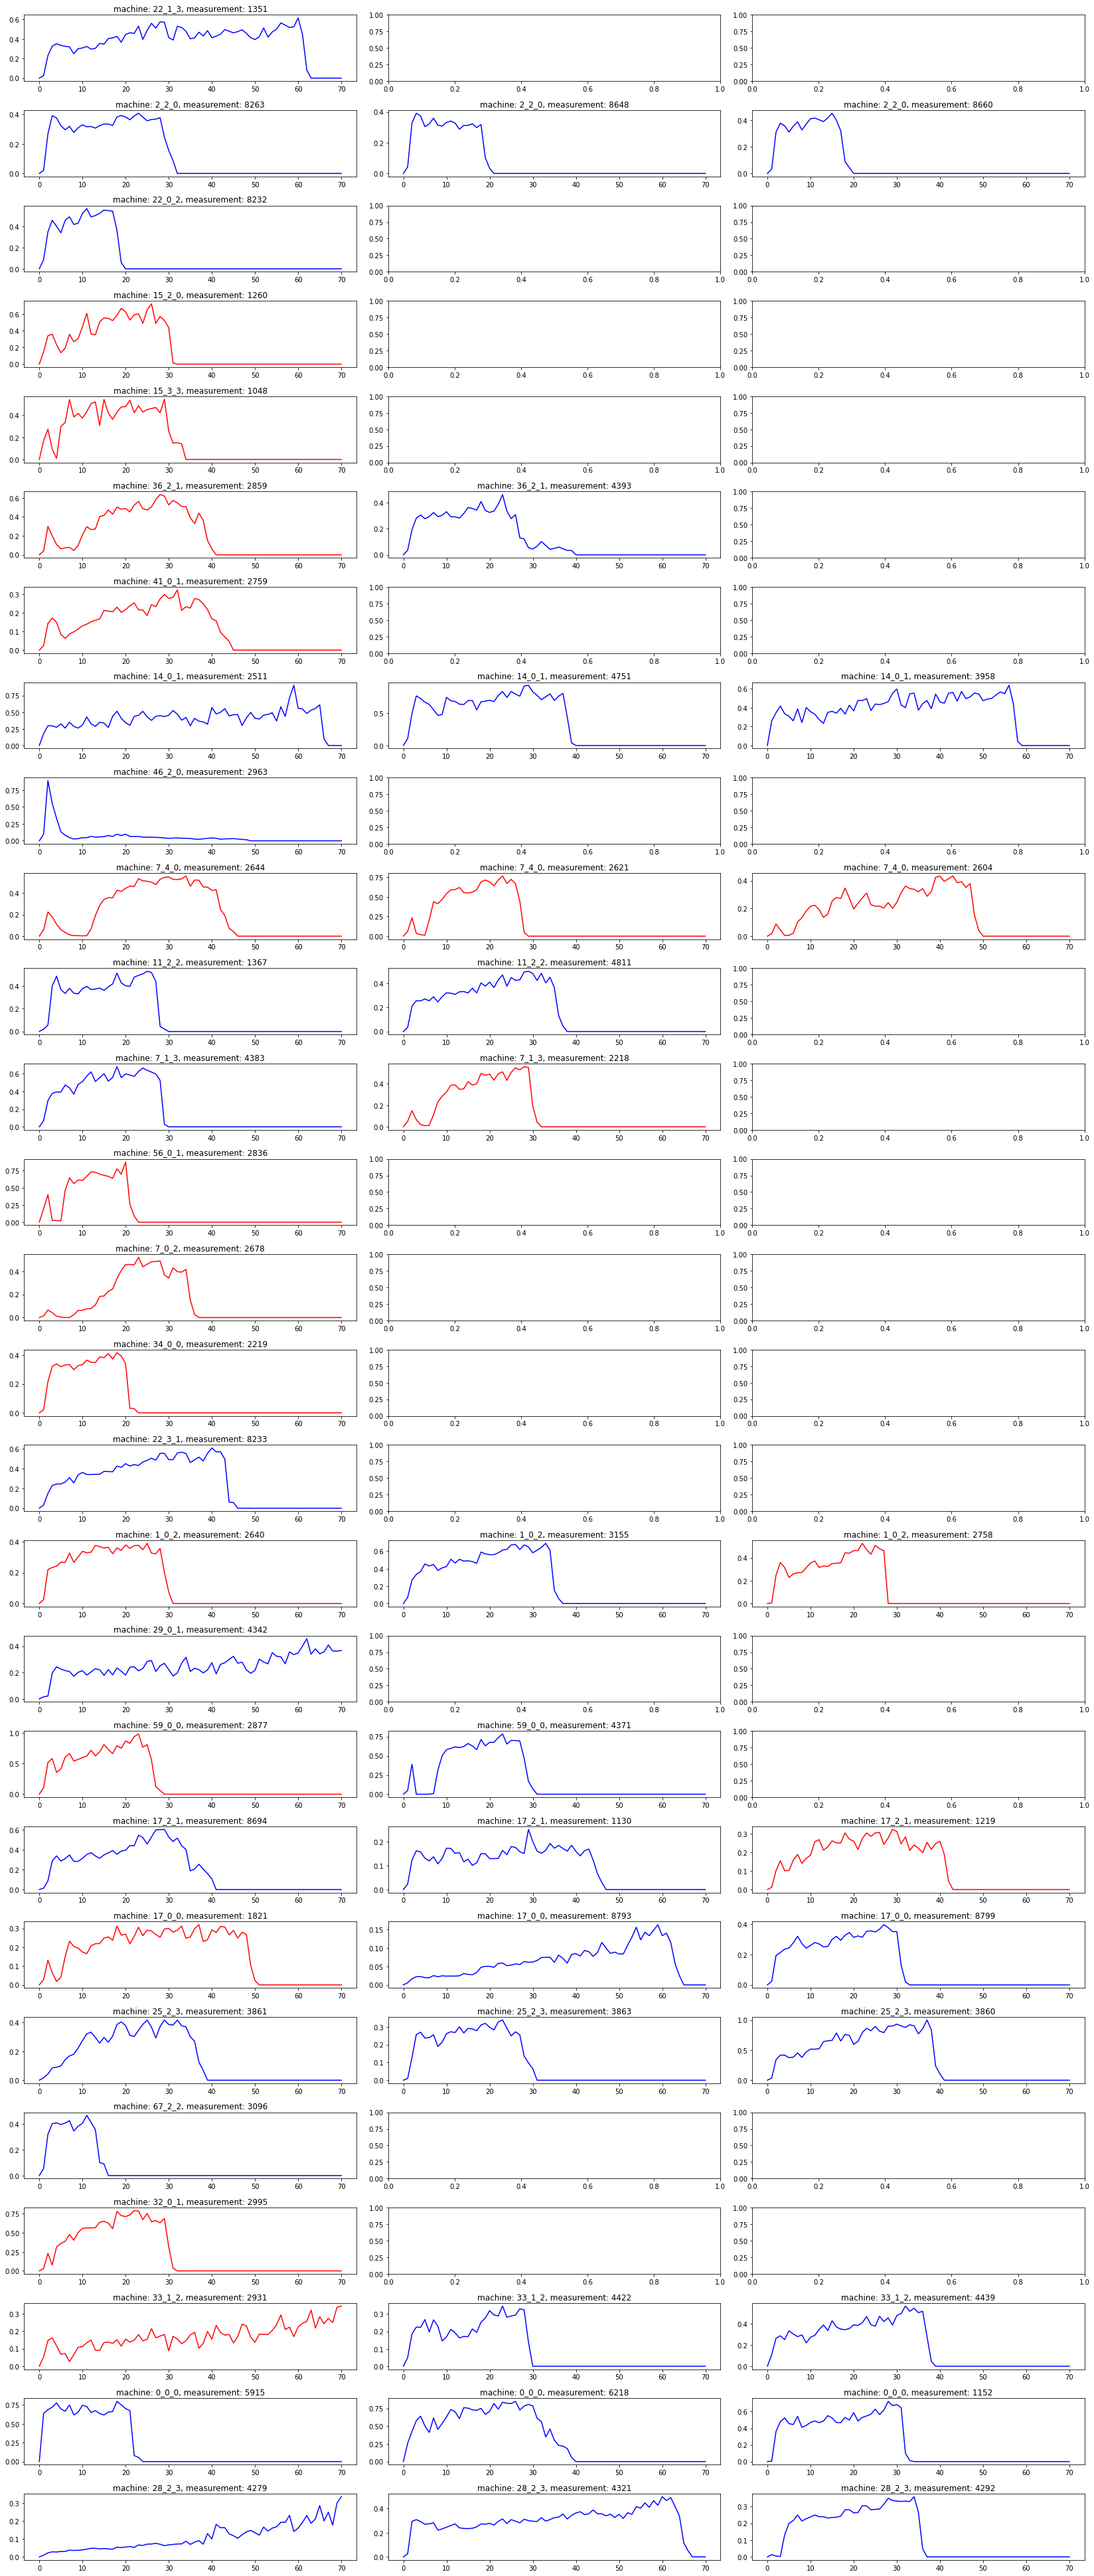

In [43]:
show_charts(df=temp_df_grouped, pressure_col='Pressure_downscale_norm_cols')

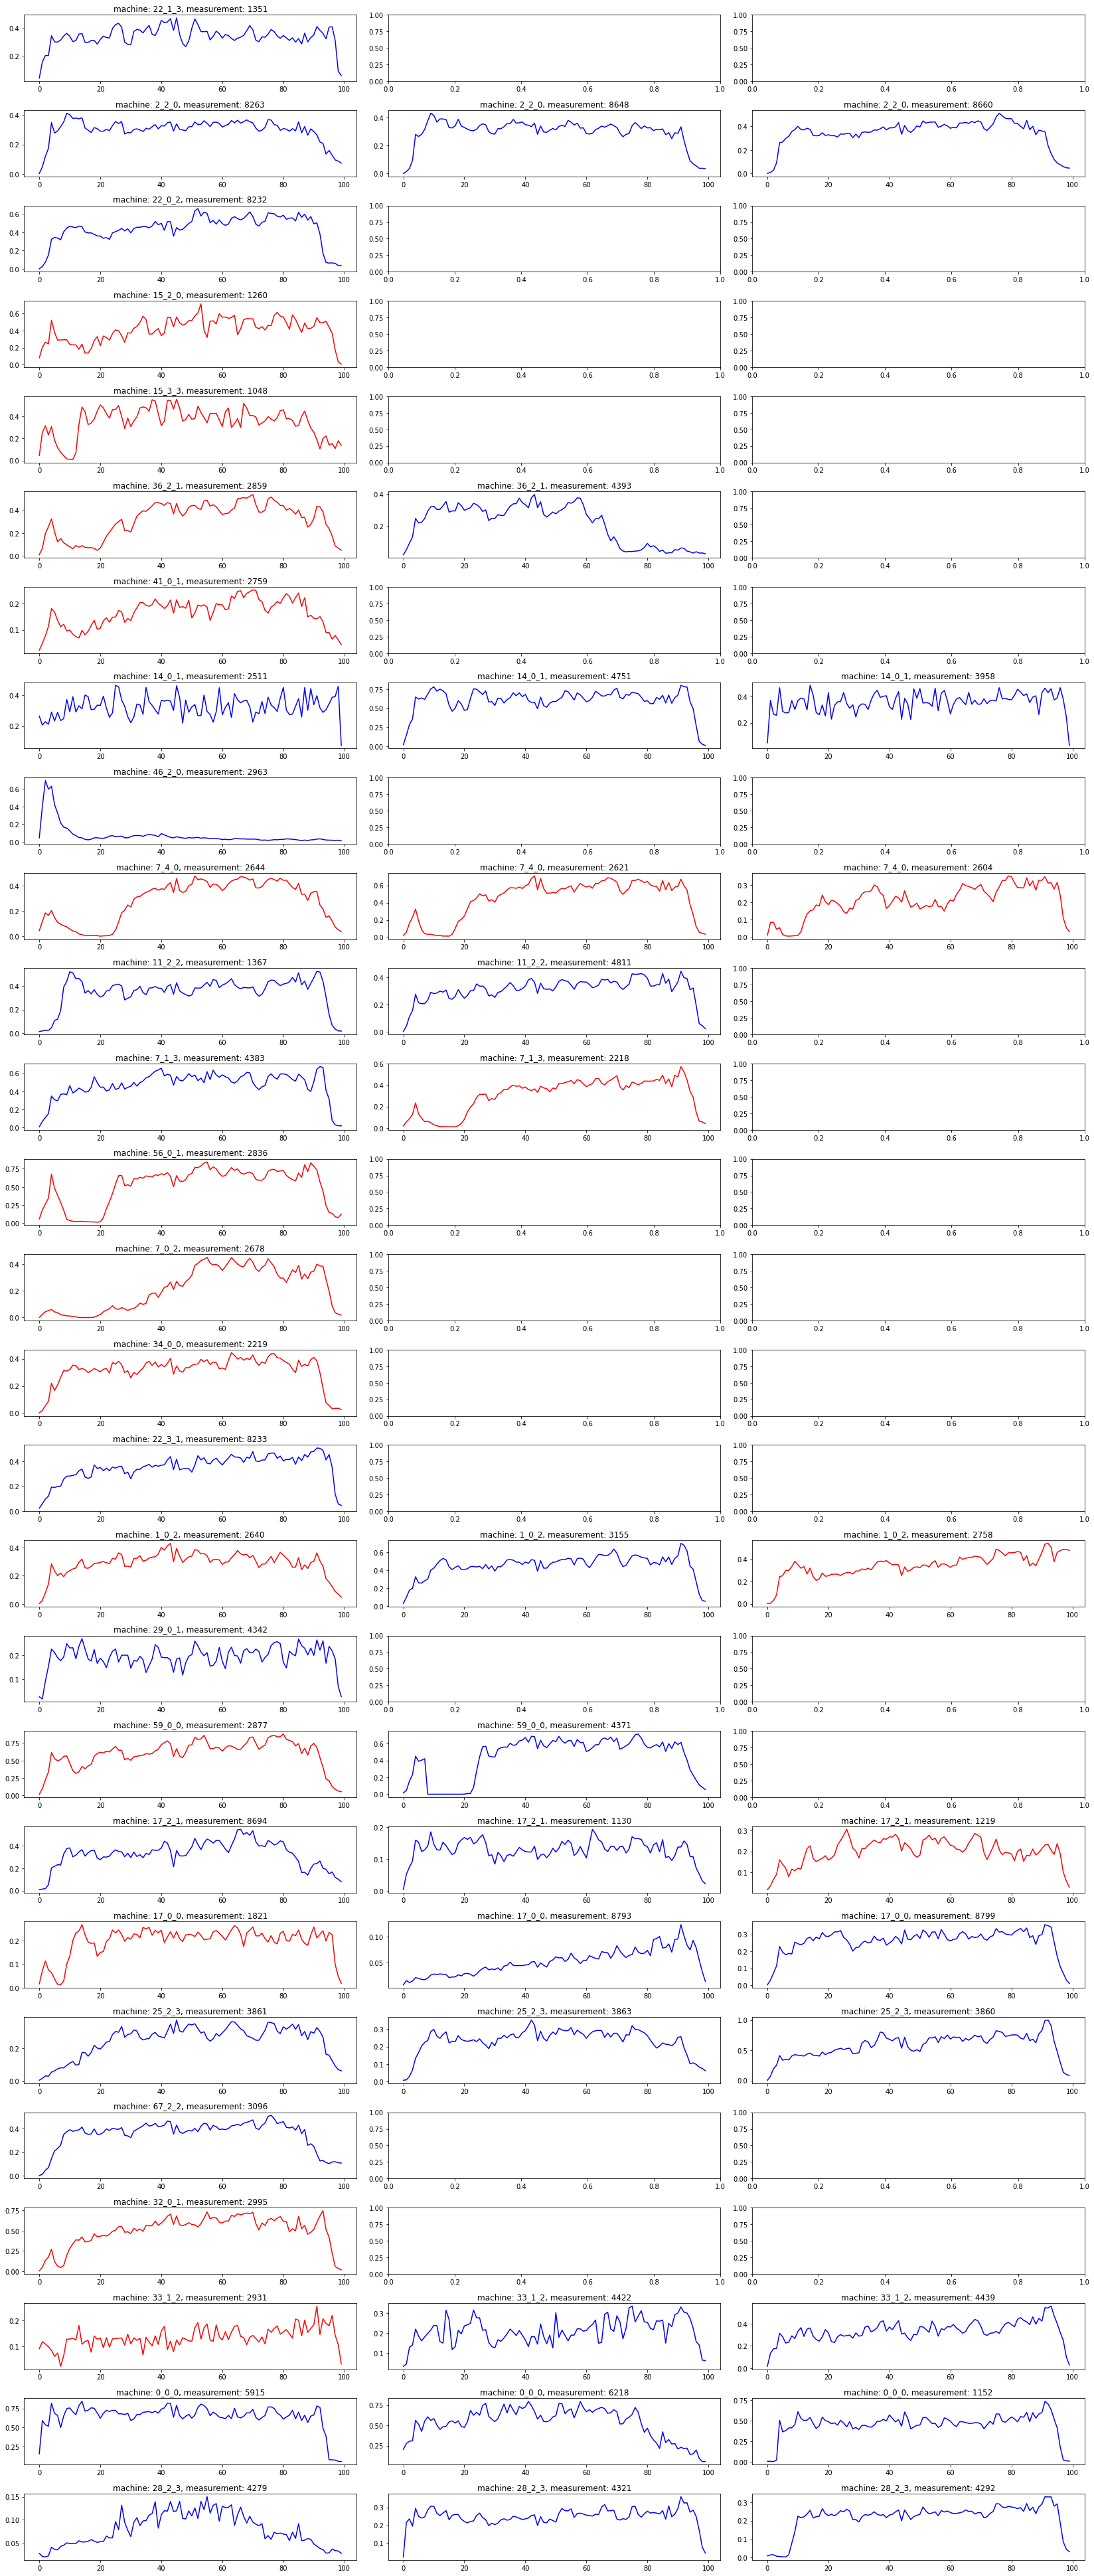

In [44]:
show_charts(df=temp_df_grouped, pressure_col='Pressure_stretch_norm_cols')

# Run all modifications to original dataframe

## Prepare copy of dataframe

In [45]:
df_adj = df.copy()

## Remove data without labels

In [46]:
df_adj = df_adj[df_adj['MeasurementId'] != -1]
df_adj

MachineId  MeasurementId  Pressure
0            0_0_0              0       0.0
1            0_0_0              0       0.0
2            0_0_0              0       0.0
3            0_0_0              0       0.0
4            0_0_0              0       0.0
...            ...            ...       ...
18466359    10_0_3           8834       0.0
18466360    10_0_3           8834       0.0
18466361    10_0_3           8834       0.0
18466362    10_0_3           8834       0.0
18466363    10_0_3           8834       0.0

[13195033 rows x 3 columns]

## Converting measurements to wide table format
So that one row equals to one measurement

In [47]:
df_adj = df_adj.groupby(['MachineId','MeasurementId']).agg({'Pressure':lambda x: list(x)}).reset_index()
df_adj

MachineId  MeasurementId  \
0         0_0_0              0   
1         0_0_0            215   
2         0_0_0            237   
3         0_0_0            353   
4         0_0_0            411   
...         ...            ...   
26895     9_5_3           4253   
26896     9_5_3           4254   
26897     9_5_3           4255   
26898     9_5_3           4256   
26899     9_5_3           4257   

                                                Pressure  
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                  ...  
26895  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
26896  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
26897  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
26898  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
26899  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[26900 rows x 3 columns]

## Cropping cycles from zeros

In [48]:
df_adj['Pressure'] = df_adj['Pressure'].apply(lambda x: remove_values_lr(x,0))
df_adj = df_adj[df_adj['Pressure'].apply(lambda x: str(x) != 'None')] #I found there are some measurements with all zeros, this must be dropped. When I checked it, it was small portion only
df_adj

MachineId  MeasurementId  \
0         0_0_0              0   
1         0_0_0            215   
2         0_0_0            237   
3         0_0_0            353   
4         0_0_0            411   
...         ...            ...   
26895     9_5_3           4253   
26896     9_5_3           4254   
26897     9_5_3           4255   
26898     9_5_3           4256   
26899     9_5_3           4257   

                                                Pressure  
0      [0.0, 0.43980582524271844, 1.0223300970873785,...  
1      [0.0, 0.34017595307917886, 0.4173998044965787,...  
2      [0.0, 1.0817669172932332, 1.0817669172932332, ...  
3      [0.0, 0.23129251700680273, 0.6209912536443148,...  
4      [0.0, 0.15188470066518847, 0.5997782705099778,...  
...                                                  ...  
26895  [0.0, 0.05916030534351145, 0.6164122137404581,...  
26896  [0.0, 0.1923474663908997, 0.8790072388831437, ...  
26897  [0.0, 0.40490196078431373, 0.40490196078431373...  
26898  [0.0, 0.32857142857142857, 1.1912087912087912,...  
26899  [0.0, 0.17060637204522097, 0.23741007194244604...  

[26838 rows x 3 columns]

## Check whether each combination of `MachineId` and `MeasurementId` is unique

In [49]:
print(len(df_adj[['MachineId','MeasurementId']].drop_duplicates()))
print(len(df_adj))
print('are combinations unique? {}'.format(len(df_adj[['MachineId','MeasurementId']].drop_duplicates()) == len(df_adj)))

26838
26838
are combinations unique? True


## Join labels

In [50]:
df_adj = pd.merge(right=df_adj, left=labels[['PumpFailed', 'MachineId', 'MeasurementId']], on=['MachineId','MeasurementId'])
df_adj.head(5)

PumpFailed MachineId  MeasurementId  \
0      False     0_0_0              0   
1      False     0_0_2              0   
2       True     0_0_3              0   
3       True     0_1_1              1   
4      False     1_0_0              2   

                                            Pressure  
0  [0.0, 0.43980582524271844, 1.0223300970873785,...  
1  [0.0, 0.3695652173913043, 0.3827977315689981, ...  
2  [0.0, 0.4022869022869023, 0.7577962577962578, ...  
3  [0.0, 0.2422680412371134, 0.6443298969072165, ...  
4  [0.0, 0.015122873345935728, 0.0803402646502835...

## Show how many measurements each machine has, select subset
Purpose of this is to keep only up to some number of measurements for each machine, so that some machines won't _overtake_ large portion of dataset. We want to avoid situations like _half of dataset consisting of cycles from one machine_.

# measurements
MachineId                
0_0_0                 568
0_0_1                 584
0_0_2                 597
0_0_3                 624
0_1_0                 627
...                   ...
9_4_3                 162
9_5_0                 136
9_5_1                 136
9_5_2                 142
9_5_3                 140

[374 rows x 1 columns]

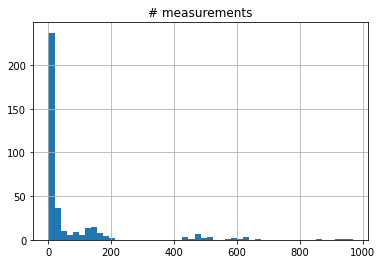

In [51]:
counts = df_adj[['MachineId','MeasurementId']].groupby('MachineId').agg(len).rename({'MeasurementId':'# measurements'},axis=1)
counts.hist(bins=50)
display(counts)

from chart above, we see how many machines (y) have how many measurements (x). Most of machines has less than ~50 measurements

### select only n measurements for each machine
see how many measurements from each machine we can take to avoid dataset bias (based on some machines with lot of measurements)

In [52]:
total_measurements = sum(counts['# measurements']) #should equal to dataset length
print(total_measurements)
print(min(counts['# measurements']))

26838
1


below we show how many measurements we get if take up to `i` measurements for each machine, and how many machines really have that number of measurements. We also plot gini which will represent inequality of number of measurements per machine. Together with gini, we will plot samples counts that we are able to get at given _max measurements per machine_ limit

In [53]:
from sklearn.metrics import auc

def gini(measurements_counts):
    """
    computes approx gini coefficient. `measurements_counts` (iterable) is vector of counts of measurements per machine.
        For example [5,2,16,11] represents 4 machines where first had 5 measurements, second 2 measurements, etc.
    """
    cumsum_relative_counts = np.cumsum(sorted(measurements_counts)) / sum(measurements_counts) #cumulative relative "wealth", y axis
    population_percent = [i/len(measurements_counts) for i in range(1,len(measurements_counts)+1)] #x axis
    area = 0.5-auc(population_percent, cumsum_relative_counts)
    gini_c = area / 0.5 #area between lorenz curve and equal state line dividied by total area below equal state line
    return gini_c

gini([1,2,3,4,5,6,7,8,9,10]) #test, should be ~.3

0.3018181818181819

In [54]:
def select_n_measurements(df, n_measurements):
    """
    select dataset samples. Maximally n_measurements for each machine
    """
    temp_df = df.copy()
    new_dfs = []
    for machine in set(df['MachineId']):
        sub_df = temp_df[temp_df['MachineId'] == machine]
        sample = sub_df.sample(n=min(n_measurements, len(sub_df)))
        new_dfs.append(sample)
        
    new_df = pd.concat(new_dfs)
    return new_df

select max 10 measurements per machine to get 2100 samples, which is 7.82% of measurements, where 163 (43.58%) machines has at least this number of measurements. Gini is 0.386, PumpFailed True class ratio is 0.273
select max 20 measurements per machine to get 3574 samples, which is 13.32% of measurements, where 138 (36.9%) machines has at least this number of measurements. Gini is 0.477, PumpFailed True class ratio is 0.237
select max 30 measurements per machine to get 4877 samples, which is 18.17% of measurements, where 117 (31.28%) machines has at least this number of measurements. Gini is 0.523, PumpFailed True class ratio is 0.218
select max 40 measurements per machine to get 5933 samples, which is 22.11% of measurements, where 101 (27.01%) machines has at least this number of measurements. Gini is 0.558, PumpFailed True class ratio is 0.198
select max 50 measurements per machine to get 6935 samples, which is 25.84% of measurements, where 100 (26.74%) machines has at least this num

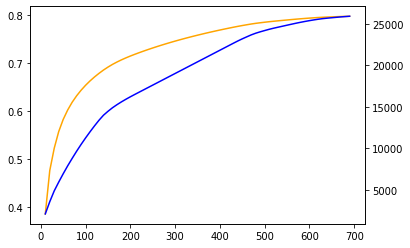

In [55]:
gini_plot, n_samples_plot, x_axis = [], [], []
for i in range(10,700,10):
    #number of machines with at least i measurements, number of measurements available with given condition
    machines_with_i_meas = len(counts[counts['# measurements'] >= i])
    number_of_measurements_machines = counts['# measurements'].apply(lambda x: min(x, i)).tolist() #counts of measurements we get from each machine with max limit
    number_of_measurements_we_get = sum(number_of_measurements_machines)
    
    #number and ratio of classes of (randomly if too many measurements) selected measurements
    approx_classes_counts = select_n_measurements(df_adj, i)['PumpFailed'].value_counts()
    approx_classes_ratio = approx_classes_counts[True] / sum(approx_classes_counts.values)
    
    #percent of data we get by current conditions
    percent_of_data = round((number_of_measurements_we_get/len(df_adj))*100,2)
    percent_of_machines = round((machines_with_i_meas/len(counts))*100,2)
    
    #gini coefficient and number of samples plot
    gini_res = gini(number_of_measurements_machines)
    gini_plot.append(gini_res)
    n_samples_plot.append(number_of_measurements_we_get)
    x_axis.append(i)
    
    #show stats
    print(f"select max {i} measurements per machine to get {number_of_measurements_we_get} samples, which is {percent_of_data}% of measurements, where {machines_with_i_meas} ({percent_of_machines}%) machines has at least this number of measurements. Gini is {round(gini_res,3)}, PumpFailed True class ratio is {round(approx_classes_ratio,3)}")

chart = plt.axes()
chart2 = chart.twinx()
chart.plot(x_axis, gini_plot, color='orange')
chart2.plot(x_axis, n_samples_plot, color='blue')
plt.show()

__Gini = Orange (left y), # of samples = Blue (right y), x axis = max number of measurements per machine__

The gini is unfortunatelly generally high. For this reason, we will select some lower max number of one machine measurements, to keep gini not too high, but not too low, to have enough samples.
 
There is also issue with balance of classes: Machines with high number of measurements, are less faulty (PumpFailed True counts ratio is getting lower while we increase max measurement number and thus we increase ratio of machines with higher number of measurements). There are multiple case scenarios:
   1. If this full dataset represents reality, it means, that faulty machines get less measurements - thus if we do measurement, probability of the measurement being faulty is lower, as probability of the machine being generally faulty is also lower. In that case we should have train / test dataset balanced with lower portion of positive samples.
   1. On the other hand, if this is going to be used to do first measurement for 100 new machines that had no past measurements, probabilty of some measurements being faulty is higher, as we are testing new machines, not just those that are already time-proven. In that case, ratio of positive samples in traininig / testing dataset should be higher

As we don't know which scenario is more real, we will to use something between.

Let's try to go with lower number, such as 100, which keeps gini still around `0.65` and will cover about 2/5 of all samples, also balance of positive samples will be somehow between both extremes.

In [56]:
df_adj = select_n_measurements(df_adj, 100).reset_index(drop=True)
df_adj

PumpFailed MachineId  MeasurementId  \
0          False    78_0_3           4385   
1          False     4_3_1           7095   
2          False     4_3_1           6863   
3          False     4_3_1           6867   
4          False     4_3_1           6808   
...          ...       ...            ...   
11245      False    14_0_3           3937   
11246      False    14_0_3           3952   
11247       True    26_2_1           1852   
11248      False    26_2_1           8769   
11249      False    26_2_1           1854   

                                                Pressure  
0      [0.0, 0.006362672322375398, 0.0487804878048780...  
1      [0.0, 0.02159827213822894, 0.05399568034557235...  
2      [0.0, 0.006815968841285297, 0.0418695228821811...  
3      [0.0, 0.04697986577181208, 0.11025886864813039...  
4      [0.0, 0.046789989118607184, 0.1360174102285092...  
...                                                  ...  
11245  [0.0, 0.18770226537216828, 0.36138079827400216...  
11246  [0.0, 0.10579857578840285, 0.37843336724313326...  
11247  [0.0, 0.10233029381965553, 0.2887537993920973,...  
11248  [0.0, 0.008364312267657992, 0.0427509293680297...  
11249  [0.0, 0.016617790811339198, 0.0547409579667644...  

[11250 rows x 4 columns]

## Resample

### Downsample using stretching
This takes about one minute

In [57]:
df_adj['Pressure_stretch'] = df_adj['Pressure'].apply(lambda x: downsample_or_upsample(x,100))
df_adj

PumpFailed MachineId  MeasurementId  \
0          False    78_0_3           4385   
1          False     4_3_1           7095   
2          False     4_3_1           6863   
3          False     4_3_1           6867   
4          False     4_3_1           6808   
...          ...       ...            ...   
11245      False    14_0_3           3937   
11246      False    14_0_3           3952   
11247       True    26_2_1           1852   
11248      False    26_2_1           8769   
11249      False    26_2_1           1854   

                                                Pressure  \
0      [0.0, 0.006362672322375398, 0.0487804878048780...   
1      [0.0, 0.02159827213822894, 0.05399568034557235...   
2      [0.0, 0.006815968841285297, 0.0418695228821811...   
3      [0.0, 0.04697986577181208, 0.11025886864813039...   
4      [0.0, 0.046789989118607184, 0.1360174102285092...   
...                                                  ...   
11245  [0.0, 0.18770226537216828, 0.36138079827400216...   
11246  [0.0, 0.10579857578840285, 0.37843336724313326...   
11247  [0.0, 0.10233029381965553, 0.2887537993920973,...   
11248  [0.0, 0.008364312267657992, 0.0427509293680297...   
11249  [0.0, 0.016617790811339198, 0.0547409579667644...   

                                        Pressure_stretch  
0      [0.006362672322375398, 0.18451749734888653, 0....  
1      [0.03779697624190065, 0.4708423326133909, 0.72...  
2      [0.04186952288218111, 0.11392405063291139, 0.1...  
3      [0.02348993288590604, 0.11025886864813039, 0.2...  
4      [0.023394994559303592, 0.19912948857453755, 0....  
...                                                  ...  
11245  [0.36138079827400216, 0.2319309600862999, 0.12...  
11246  [0.10579857578840285, 0.9120040691759919, 0.94...  
11247  [0.05116514690982776, 0.4635258358662614, 0.94...  
11248  [0.008364312267657992, 0.2611524163568773, 0.7...  
11249  [0.016617790811339198, 0.0, 0.0, 0.02199413489...  

[11250 rows x 5 columns]

### Downsample using dimension reduction and padding
This takes about one minute

In [58]:
df_adj['Pressure_downscale'] = df_adj['Pressure'].apply(lambda x: downsample_into_n_points(x, n_samples=None, group_size=5))
df_adj['Pressure_downscale'] = df_adj['Pressure_downscale'].apply(lambda x: [0]+rpad(x, total_length=70))
df_adj

PumpFailed MachineId  MeasurementId  \
0          False    78_0_3           4385   
1          False     4_3_1           7095   
2          False     4_3_1           6863   
3          False     4_3_1           6867   
4          False     4_3_1           6808   
...          ...       ...            ...   
11245      False    14_0_3           3937   
11246      False    14_0_3           3952   
11247       True    26_2_1           1852   
11248      False    26_2_1           8769   
11249      False    26_2_1           1854   

                                                Pressure  \
0      [0.0, 0.006362672322375398, 0.0487804878048780...   
1      [0.0, 0.02159827213822894, 0.05399568034557235...   
2      [0.0, 0.006815968841285297, 0.0418695228821811...   
3      [0.0, 0.04697986577181208, 0.11025886864813039...   
4      [0.0, 0.046789989118607184, 0.1360174102285092...   
...                                                  ...   
11245  [0.0, 0.18770226537216828, 0.36138079827400216...   
11246  [0.0, 0.10579857578840285, 0.37843336724313326...   
11247  [0.0, 0.10233029381965553, 0.2887537993920973,...   
11248  [0.0, 0.008364312267657992, 0.0427509293680297...   
11249  [0.0, 0.016617790811339198, 0.0547409579667644...   

                                        Pressure_stretch  \
0      [0.006362672322375398, 0.18451749734888653, 0....   
1      [0.03779697624190065, 0.4708423326133909, 0.72...   
2      [0.04186952288218111, 0.11392405063291139, 0.1...   
3      [0.02348993288590604, 0.11025886864813039, 0.2...   
4      [0.023394994559303592, 0.19912948857453755, 0....   
...                                                  ...   
11245  [0.36138079827400216, 0.2319309600862999, 0.12...   
11246  [0.10579857578840285, 0.9120040691759919, 0.94...   
11247  [0.05116514690982776, 0.4635258358662614, 0.94...   
11248  [0.008364312267657992, 0.2611524163568773, 0.7...   
11249  [0.016617790811339198, 0.0, 0.0, 0.02199413489...   

                                      Pressure_downscale  
0      [0, 0.04878048780487805, 0.5344644750795334, 0...  
1      [0, 0.05399568034557235, 0.6382289416846653, 0...  
2      [0, 0.04186952288218111, 0.124634858812074, 0....  
3      [0, 0.11025886864813039, 0.7037392138063279, 0...  
4      [0, 0.13601741022850924, 0.7780195865070729, 0...  
...                                                  ...  
11245  [0, 0.36138079827400216, 0.42179072276159657, ...  
11246  [0, 0.37843336724313326, 1.0528992878942014, 1...  
11247  [0, 0.2887537993920973, 1.2168186423505571, 1....  
11248  [0, 0.04275092936802974, 0.7555762081784386, 0...  
11249  [0, 0.0, 0.0, 0.06940371456500488, 0.008797653...  

[11250 rows x 6 columns]

## Normalize pressure

### Normalize within cycles

In [59]:
df_adj['Pressure_downscale_norm'] = df_adj['Pressure_downscale'].apply(lambda x: minmax_scale(x))
df_adj['Pressure_stretch_norm'] = df_adj['Pressure_stretch'].apply(lambda x: minmax_scale(x))
df_adj.head(5)

PumpFailed MachineId  MeasurementId  \
0      False    78_0_3           4385   
1      False     4_3_1           7095   
2      False     4_3_1           6863   
3      False     4_3_1           6867   
4      False     4_3_1           6808   

                                            Pressure  \
0  [0.0, 0.006362672322375398, 0.0487804878048780...   
1  [0.0, 0.02159827213822894, 0.05399568034557235...   
2  [0.0, 0.006815968841285297, 0.0418695228821811...   
3  [0.0, 0.04697986577181208, 0.11025886864813039...   
4  [0.0, 0.046789989118607184, 0.1360174102285092...   

                                    Pressure_stretch  \
0  [0.006362672322375398, 0.18451749734888653, 0....   
1  [0.03779697624190065, 0.4708423326133909, 0.72...   
2  [0.04186952288218111, 0.11392405063291139, 0.1...   
3  [0.02348993288590604, 0.11025886864813039, 0.2...   
4  [0.023394994559303592, 0.19912948857453755, 0....   

                                  Pressure_downscale  \
0  [0, 0.04878048780487805, 0.5344644750795334, 0...   
1  [0, 0.05399568034557235, 0.6382289416846653, 0...   
2  [0, 0.04186952288218111, 0.124634858812074, 0....   
3  [0, 0.11025886864813039, 0.7037392138063279, 0...   
4  [0, 0.13601741022850924, 0.7780195865070729, 0...   

                             Pressure_downscale_norm  \
0  [0.0, 0.06157965194109772, 0.6746987951807228,...   
1  [0.0, 0.04038772213247173, 0.4773828756058159,...   
2  [0.0, 0.14878892733564014, 0.4429065743944637,...   
3  [0.0, 0.10369702434625788, 0.6618575293056808,...   
4  [0.0, 0.11332728921124206, 0.6482320942883046,...   

                               Pressure_stretch_norm  
0  [0.0, 0.224, 0.6140000000000001, 0.776, 0.8066...  
1  [0.0, 0.32681336593317034, 0.5167074164629177,...  
2  [0.025742574257425765, 0.31881188118811876, 0....  
3  [0.0, 0.07991169977924943, 0.2225165562913907,...  
4  [0.0, 0.1454299864925709, 0.3489419180549302, ...

### Normalize within columns

In [60]:
df_adj['Pressure_downscale_norm_cols'] = normalize_over_columns(df_adj, 'Pressure_downscale')
df_adj['Pressure_stretch_norm_cols'] = normalize_over_columns(df_adj, 'Pressure_stretch')

## Shuffle dataset

In [61]:
df_adj_shuff = df_adj.sample(frac=1., random_state=42).reset_index(drop=True)
df_adj_shuff.head(5)

PumpFailed MachineId  MeasurementId  \
0      False     4_0_0           7182   
1       True     3_0_3           1687   
2       True     9_5_2           2907   
3      False     4_2_1           2222   
4      False     2_2_1           8654   

                                            Pressure  \
0  [0.0, 0.036585365853658534, 0.1491557223264540...   
1  [0.0, 0.08333333333333333, 0.10897435897435898...   
2  [0.0, 0.3643243243243243, 0.6681081081081081, ...   
3  [0.0, 0.007332722273143905, 0.0384967919340055...   
4  [0.0, 0.015902712815715623, 0.0467726847521047...   

                                    Pressure_stretch  \
0  [0.018292682926829267, 0.2396810506566604, 0.4...   
1  [0.041666666666666664, 0.13194444444444445, 0....   
2  [0.18216216216216216, 0.6681081081081081, 1.01...   
3  [0.007332722273143905, 0.12328139321723189, 0....   
4  [0.04677268475210477, 0.2516370439663237, 0.24...   

                                  Pressure_downscale  \
0  [0, 0.14915572232645402, 0.6904315196998124, 0...   
1  [0, 0.10897435897435898, 0.483974358974359, 0....   
2  [0, 0.6681081081081081, 0.84, 0.95567567567567...   
3  [0, 0.0384967919340055, 0.4555453712190651, 0....   
4  [0, 0.04677268475210477, 0.2516370439663237, 0...   

                             Pressure_downscale_norm  \
0  [0.0, 0.15114068441064638, 0.699619771863118, ...   
1  [0.0, 0.0750551876379691, 0.33333333333333337,...   
2  [0.0, 0.5255102040816326, 0.6607142857142857, ...   
3  [0.0, 0.029640084685956247, 0.3507410021171489...   
4  [0.0, 0.07936507936507937, 0.4269841269841271,...   

                               Pressure_stretch_norm  \
0  [0.009467989179440934, 0.2222723174030658, 0.4...   
1  [0.0, 0.06174643770551699, 0.1658750456704421,...   
2  [0.057445442875481395, 0.3459563543003851, 0.5...   
3  [0.0, 0.08784722222222222, 0.1885416666666667,...   
4  [0.0, 0.35322580645161294, 0.34838709677419355...   

                        Pressure_downscale_norm_cols  \
0  [0.0, 0.0398776162764685, 0.22197813876436548,...   
1  [0.0, 0.029134904134904136, 0.1556008443263345...   
2  [0.0, 0.17862243801830446, 0.2700653594771242,...   
3  [0.0, 0.010292332554693044, 0.1464607433766866...   
4  [0.0, 0.012504938769176925, 0.0809029151625310...   

                          Pressure_stretch_norm_cols  
0  [0.008304019834290436, 0.0640800689222497, 0.1...  
1  [0.018914711844772662, 0.03527608490843785, 0....  
2  [0.08269307535163313, 0.17862243801830446, 0.2...  
3  [0.00332871189202232, 0.03295996972871939, 0.0...  
4  [0.02123260450301889, 0.06727657057817187, 0.0...

# Modeling
In this part, we will do model. I am going to use just logistic regression, because the project should be finished fast and model should be explained. If the model based on logistic regression shows to be at least better (in cross validation) than random guessing, then it will be tested also on final test set.

I will use `sklearn`, as it's faster than writing everything from scratch (or than using things like `scipy.optimize`, etc.):

In [62]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, average_precision_score, precision_recall_curve, accuracy_score, recall_score, precision_score



## Conditional train test split
We do train test split, such way, that 25% of machines is in test, rest in train.

The purpose is not to have any machines that are both in train and test, because if some machine has specific behavior for failure / not failure (even during various measurements), that could lead to overestimating quality of our model. It would lead to the fact, that when there is completely new machine without any measurements, model would not be able to predict pump failure properly on it.

For reason above, we use train/test and cross validation splitting conditioned on `MachineId` column

In [63]:
unique_machines = df_adj_shuff['MachineId'].unique()
num_machines = len(unique_machines)
print(f"there is {num_machines} machines, for train we take {int(num_machines*.75)} of them")

#shuffle unique machines. The reason is (as I found out), that unique values are sorted approximatelly from most to least frequent value, although we took them from shuffled dataset.
#    Even if we take unique values from shuffled dataset, we need to shuffle them again. If we select random value from shuffled dataset, the probability of picked value being the most frequent one is
#    much higher than probability of picking other values. From this we see that unshuffled unique values would be approximatelly sorted from most frequent to least
shuffled_machines = np.random.choice(unique_machines, num_machines, replace=False) #or I could use np.random.choice with fraction .8 and that would be machines for train

#select machines for train and test
train_machines = set(shuffled_machines[:int(num_machines*.75)])
test_machines = set(shuffled_machines)-train_machines
print(f"final number of train machines is {len(train_machines)}, number of test machines is {len(test_machines)}")

#split dataset
df_adj_shuff_tr = df_adj_shuff[df_adj_shuff['MachineId'].isin(train_machines)].reset_index(drop=True)
df_adj_shuff_ts = df_adj_shuff[df_adj_shuff['MachineId'].isin(test_machines)].reset_index(drop=True)
print(f"number of samples train: {len(df_adj_shuff_tr)}, # of samples test {len(df_adj_shuff_ts)}, ratio of train is {round(len(df_adj_shuff_tr)/len(df_adj_shuff),2)}")

there is 374 machines, for train we take 280 of them
final number of train machines is 280, number of test machines is 94
number of samples train: 7984, # of samples test 3266, ratio of train is 0.71


### Check ratio of positive and negative samples
We will do some data balancing, if the ratio of positive and negative is heavily unbalanced (such as 0.01), but generally, if it's not less than 0.1, we won't rebalance the data. The reason is to keep real distribution (adjusted by limited number of measurements per machine) of positive and negative samples

In [64]:
tr_class_counts = df_adj_shuff_tr['PumpFailed'].value_counts()
ts_class_counts = df_adj_shuff_ts['PumpFailed'].value_counts()
print('train positive ratio: ',tr_class_counts[True] / sum(tr_class_counts.values))
print('test positive ratio: ',ts_class_counts[True] / sum(ts_class_counts.values))

train positive ratio:  0.14804609218436873
test positive ratio:  0.16044090630740968


The real data ratio is unbalanced, however, as it corresponds to reality, and the ratio is within reasonable bounds, we will keep it as it is

## Conditional splitting of train into folds, preparing target variable
We will use grouped kfold to split train. We split it into 4 groups for cross validation training.
Get true target classes vector for train, this will be common for all train models (but we will have different X, see below):

In [65]:
y = df_adj_shuff_tr['PumpFailed'].astype(int)

Next, we create `StratifiedGroupKFold` class which allows us to quickly create folds with approximatelly same ratios of classes, fulfiling desired condition, that one machine cannot be both in train and test for given fold. It's the same that was applied for train and test. Note that folds contains only indices of `X` and `y`, not features and target themselves. This is good for flexibility, as we can use multiple `X` dataset, if they have same length. As we have some different transformation applied on _Pressure_, this will be useful

In [66]:
kfold = StratifiedGroupKFold(4)
groups = df_adj_shuff_tr['MachineId']
kfolds = kfold.split(X=df_adj_shuff_tr,y=y,groups=groups) #we don't need to provide exactly X and y data, as kfolds will represent only indices of folds, not final data. This makes everything more flexible
kfolds = list(kfolds)
kfolds

[(array([   0,    1,    2, ..., 7980, 7981, 7982]),
  array([   6,    7,   17, ..., 7976, 7977, 7983])),
 (array([   2,    6,    7, ..., 7981, 7982, 7983]),
  array([   0,    1,    3, ..., 7973, 7979, 7980])),
 (array([   0,    1,    3, ..., 7981, 7982, 7983]),
  array([   2,    8,    9, ..., 7969, 7970, 7972])),
 (array([   0,    1,    2, ..., 7979, 7980, 7983]),
  array([  13,   14,   18, ..., 7978, 7981, 7982]))]

Let's check some information about data. Whether the distribution of positives and negatives is similar accross folds, and whether really no machine from train is in test

In [67]:
for idx, fold in enumerate(kfolds):
    train_indices, test_indices = fold
    machines_train = set(df_adj_shuff_tr['MachineId'][train_indices])
    machines_test = set(df_adj_shuff_tr['MachineId'][test_indices])
    pos_count_tr, neg_count_tr = y[train_indices].value_counts()[1], y[train_indices].value_counts()[0]
    pos_count_ts, neg_count_ts = y[test_indices].value_counts()[1], y[test_indices].value_counts()[0]
    print(f"Fold #{idx} | Machines common in train and test (ideally 0): {machines_train.intersection(machines_test)}. # machines train, test: {len(machines_train)}, {len(machines_test)} | # samples: train, test: {len(train_indices)}, {len(test_indices)} pos/neg train: {pos_count_tr}/{neg_count_tr} (pos:{round((pos_count_tr/(pos_count_tr+neg_count_tr))*100,1)}% of all), pos/neg test: {pos_count_ts}/{neg_count_ts} (pos:{round((pos_count_ts/(pos_count_ts+neg_count_ts))*100,1)}% of all)")

Fold #0 | Machines common in train and test (ideally 0): set(). # machines train, test: 197, 83 | # samples: train, test: 5991, 1993 pos/neg train: 886/5105 (pos:14.8% of all), pos/neg test: 296/1697 (pos:14.9% of all)
Fold #1 | Machines common in train and test (ideally 0): set(). # machines train, test: 215, 65 | # samples: train, test: 5991, 1993 pos/neg train: 887/5104 (pos:14.8% of all), pos/neg test: 295/1698 (pos:14.8% of all)
Fold #2 | Machines common in train and test (ideally 0): set(). # machines train, test: 203, 77 | # samples: train, test: 5991, 1993 pos/neg train: 886/5105 (pos:14.8% of all), pos/neg test: 296/1697 (pos:14.9% of all)
Fold #3 | Machines common in train and test (ideally 0): set(). # machines train, test: 225, 55 | # samples: train, test: 5979, 2005 pos/neg train: 887/5092 (pos:14.8% of all), pos/neg test: 295/1710 (pos:14.7% of all)


## Prepare scorers, these will be useful for cross validation
Here we prepare roc scorer, average precision scorer, charts functions and function to report cv scores

In [68]:
roc_auc_cv = make_scorer(roc_auc_score, needs_proba=True)
avs = make_scorer(average_precision_score, needs_proba=True)

also we prepare best f1 score calculation function (that can be used directly as scorer)

In [69]:
def get_all_scores(estimator, X, y):
    """
    returns all following scores: roc auc, pr auc, best f1, precision at best f1, recall at best f1, best f1 threshold
    """
    #get roc auc and pr auc using prepared scorers, that accepts same arguments as this global scorer
    roc = roc_auc_cv(estimator, X, y)
    pr = avs(estimator, X, y)
    
    #get f1 scores, using pr curve
    y_pred = estimator.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
    F1 = np.nan_to_num(F1)
    top_f1_idx = np.argmax(F1)
    
    #get accuracy at best F1
    acc = accuracy_score(y, np.array(estimator.predict_proba(X)[:,1] > thresholds[top_f1_idx]).astype(int))
    return {'roc':roc,'pr':pr,'recall_at_topf1':recall[top_f1_idx], 'precision_at_topf1':precision[top_f1_idx], 'topf1':F1[top_f1_idx], 'topf1_threshold':thresholds[top_f1_idx], 'accuracy_at_topf1':acc}

In [70]:
def plot_single_curve_pair(chart, tr_x, tr_y, ts_x, ts_y, tr_auc, ts_auc, mode='roc'):
    mode_settings = {'roc':
                         {'color_tr':'navy', 'color_ts':'salmon',
                          'label_tr':f"ROC curve train (area = {round(tr_auc,2)})",'label_ts':f"ROC curve test (area = {round(ts_auc,2)})",
                          'xlabel':'False Positive Rate', 'ylabel':'True Positive Rate',
                          'title':'Receiver operating characteristic', 'legend':'lower right', 'diagonal_linestyle':'--'},
                     'pr':
                         {'color_tr':'olive', 'color_ts':'purple',
                          'label_tr':f"PR curve train (area = {round(tr_auc,2)}",'label_ts':f"PR curve test (area = {round(ts_auc,2)})",
                          'xlabel':'Recall', 'ylabel':'Precision',
                          'title':'Precision Recall curve', 'legend':'lower right', 'diagonal_linestyle':''}
                     }
    s = mode_settings
    chart.plot(tr_x,tr_y,color=s[mode]['color_tr'],lw=2,label=s[mode]['label_tr'])
    chart.plot(ts_x,ts_y,color=s[mode]['color_ts'],lw=2,label=s[mode]['label_ts'])
    chart.plot([0, 1], [0, 1], color="gray", lw=2, linestyle=s[mode]['diagonal_linestyle'])
    chart.set_xlim([0.0, 1.0])
    chart.set_ylim([0.0, 1.0])
    chart.set_xlabel(s[mode]['xlabel'])
    chart.set_ylabel(s[mode]['ylabel'])
    chart.set_title(s[mode]['title'])
    chart.legend(loc=s[mode]['legend'])
    
def plot_coefs(chart, coefs_series):
    chart.bar(x=coefs_series.index, height=coefs_series, color='goldenrod')
    chart.set_xlabel('feature; index of measurement/s (s - if resampled)')
    chart.set_ylabel('feature value')
    chart.set_title('weights of model, showing measurements importance over time')
    
def show_cv_results(cv, X, y, folds):
    fig, charts = plt.subplots(ncols=4, nrows=3, figsize=(27,14))

    for idx, est in enumerate(cv['estimator']):
        coefs = pd.Series(cv['estimator'][idx].coef_[0])

        y_train_real, y_test_real = y[kfolds[idx][0]], y[kfolds[idx][1]]
        y_train_pred, y_test_pred = cv['estimator'][idx].predict_proba(X[kfolds[idx][0]])[:,1], cv['estimator'][idx].predict_proba(X[kfolds[idx][1]])[:,1]

        #roc
        roc_auc_tr = roc_auc_score(y_train_real, y_train_pred)
        fpr_tr, tpr_tr, thr_tr = roc_curve(y_train_real, y_train_pred)

        roc_auc_ts = roc_auc_score(y_test_real, y_test_pred)
        fpr_ts, tpr_ts, thr_ts = roc_curve(y_test_real, y_test_pred)

        #pr
        pr_auc_tr = average_precision_score(y_train_real, y_train_pred)
        p_tr, r_tr, thr_tr = precision_recall_curve(y_train_real, y_train_pred)

        pr_auc_ts = average_precision_score(y_test_real, y_test_pred)
        p_ts, r_ts, thr_ts = precision_recall_curve(y_test_real, y_test_pred)
        
        plot_single_curve_pair(charts[0][idx], fpr_tr, tpr_tr, fpr_ts, tpr_ts, roc_auc_tr, roc_auc_ts, mode='roc') #roc
        plot_single_curve_pair(charts[1][idx], r_tr, p_tr, r_ts, p_ts, pr_auc_tr, pr_auc_ts, mode='pr') #pr
        plot_coefs(charts[2][idx], coefs)

    plt.tight_layout()
    plt.show()

## Train models with cv and show results
For time reasons, we won't be doing anything like grid search or any other parameter optimization, if we will be able to get good models with some basic parameters. I have already tried cross validation with few different regularization strength coefficients, and finally value of `0.2` seemed to work quite well (note that sklearn parameter `C` correspond to inverted regularization strength)

### Train on downsampled sretched data non-normalized

In [71]:
X = np.array(df_adj_shuff_tr['Pressure_stretch'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models1 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models1

C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recal

{'fit_time': array([5.38353682, 5.4499166 , 5.73535204, 5.39808059]),
 'score_time': array([0.00202799, 0.00804734, 0.00203109, 0.00799561]),
 'estimator': [LogisticRegression(C=0.2, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.2, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.2, max_iter=500, penalty='l1', solver='saga'),
  LogisticRegression(C=0.2, max_iter=500, penalty='l1', solver='saga')],
 'test_roc': array([0.81548121, 0.82590485, 0.81272994, 0.82652394]),
 'train_roc': array([0.82874821, 0.8254222 , 0.83242362, 0.83030591]),
 'test_pr': array([0.5316223 , 0.61892209, 0.60755471, 0.56220733]),
 'train_pr': array([0.60862751, 0.57634072, 0.5874385 , 0.59261979]),
 'test_recall_at_topf1': array([0.61824324, 0.65084746, 0.5777027 , 0.58983051]),
 'train_recall_at_topf1': array([0.6027088 , 0.56369786, 0.58577878, 0.61781285]),
 'test_precision_at_topf1': array([0.58466454, 0.66206897, 0.61071429, 0.58389262]),
 'train_precision_at_topf1

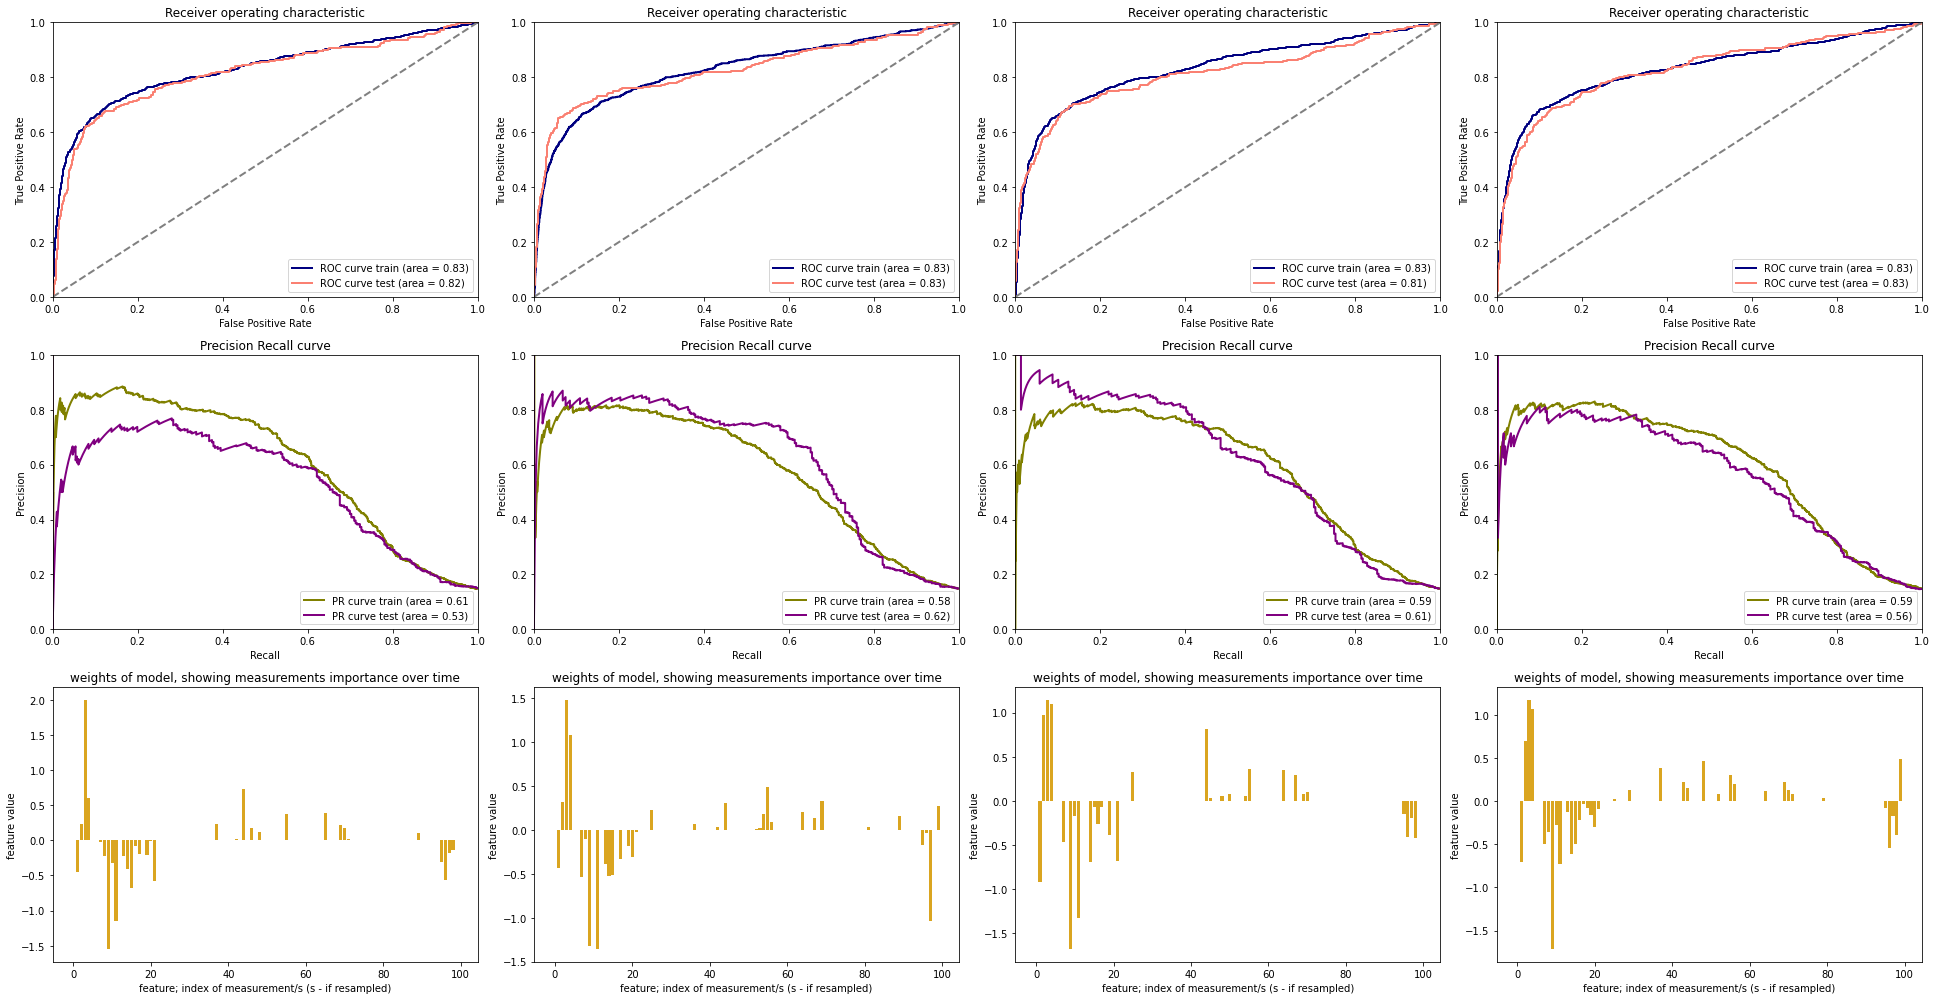

In [72]:
show_cv_results(cv_models1, X, y, kfolds)

### Train on downsampled stretched data normalized within cycles

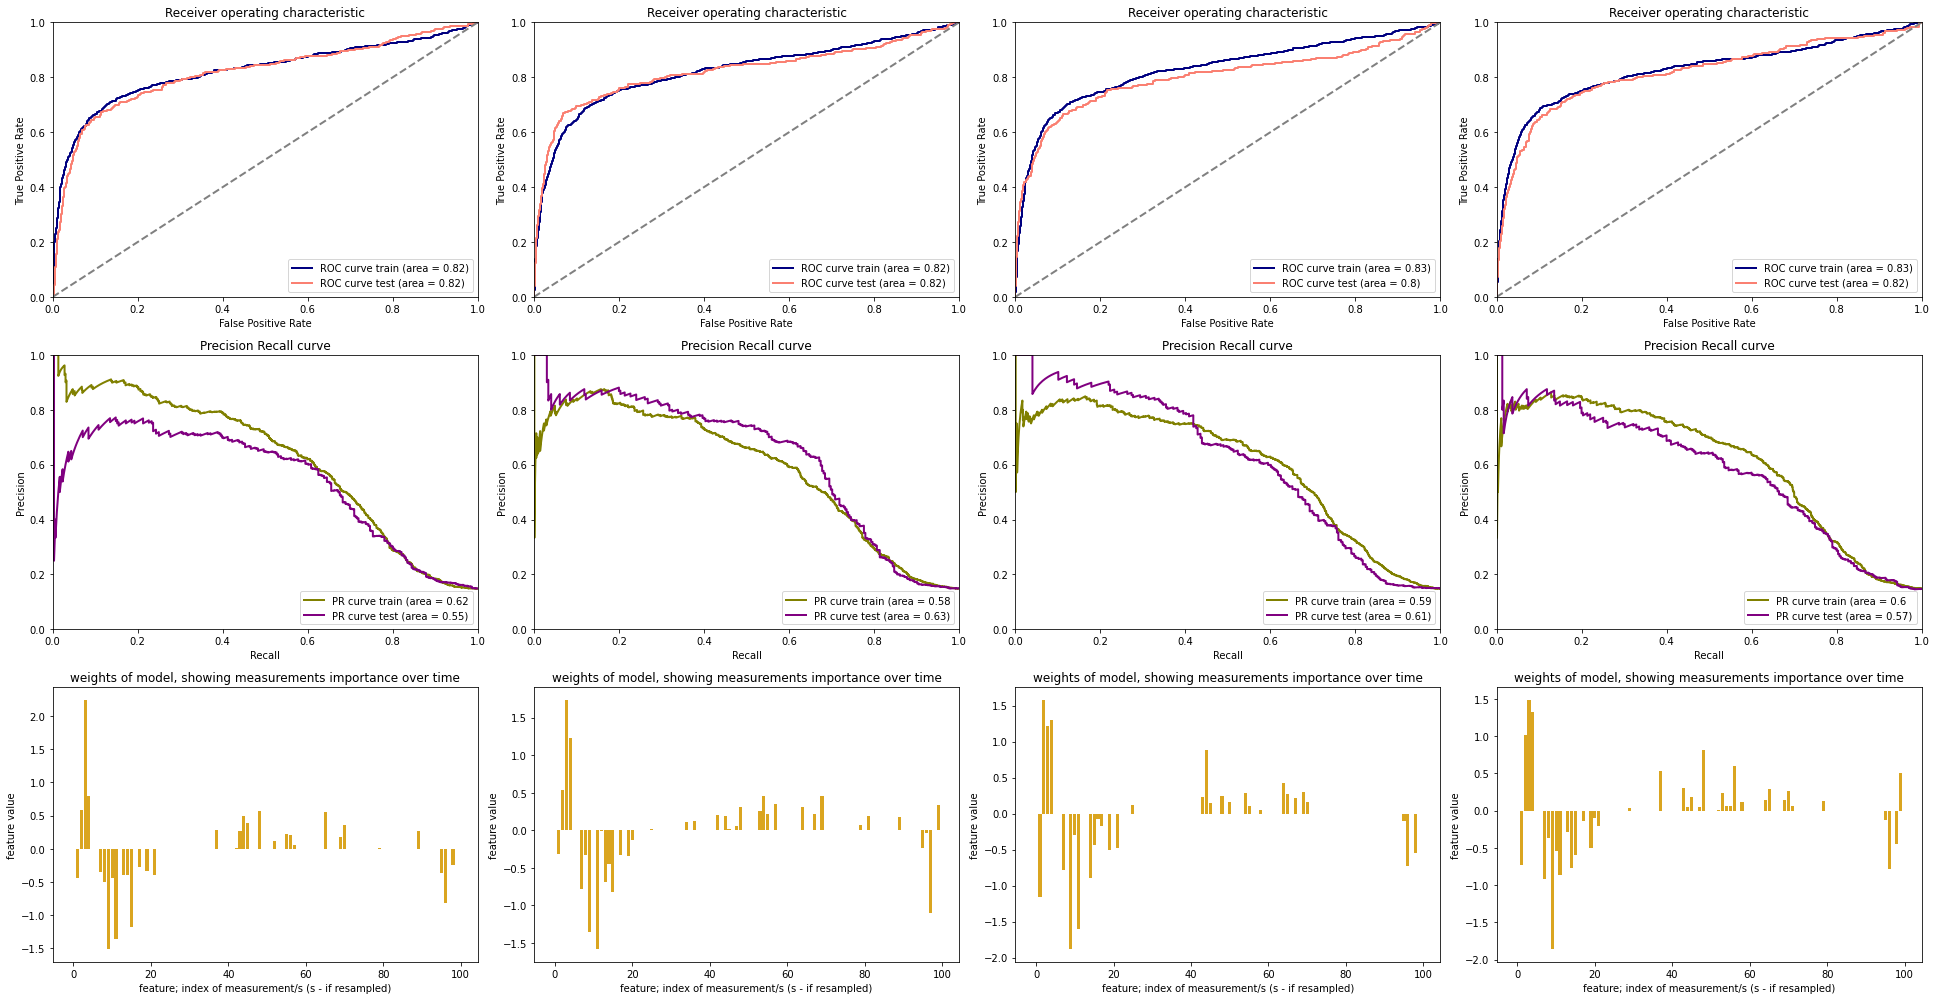

In [73]:
X = np.array(df_adj_shuff_tr['Pressure_stretch_norm'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models2 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models2
show_cv_results(cv_models2, X, y, kfolds)

### Train on downsampled stretched data normalized within columns

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds


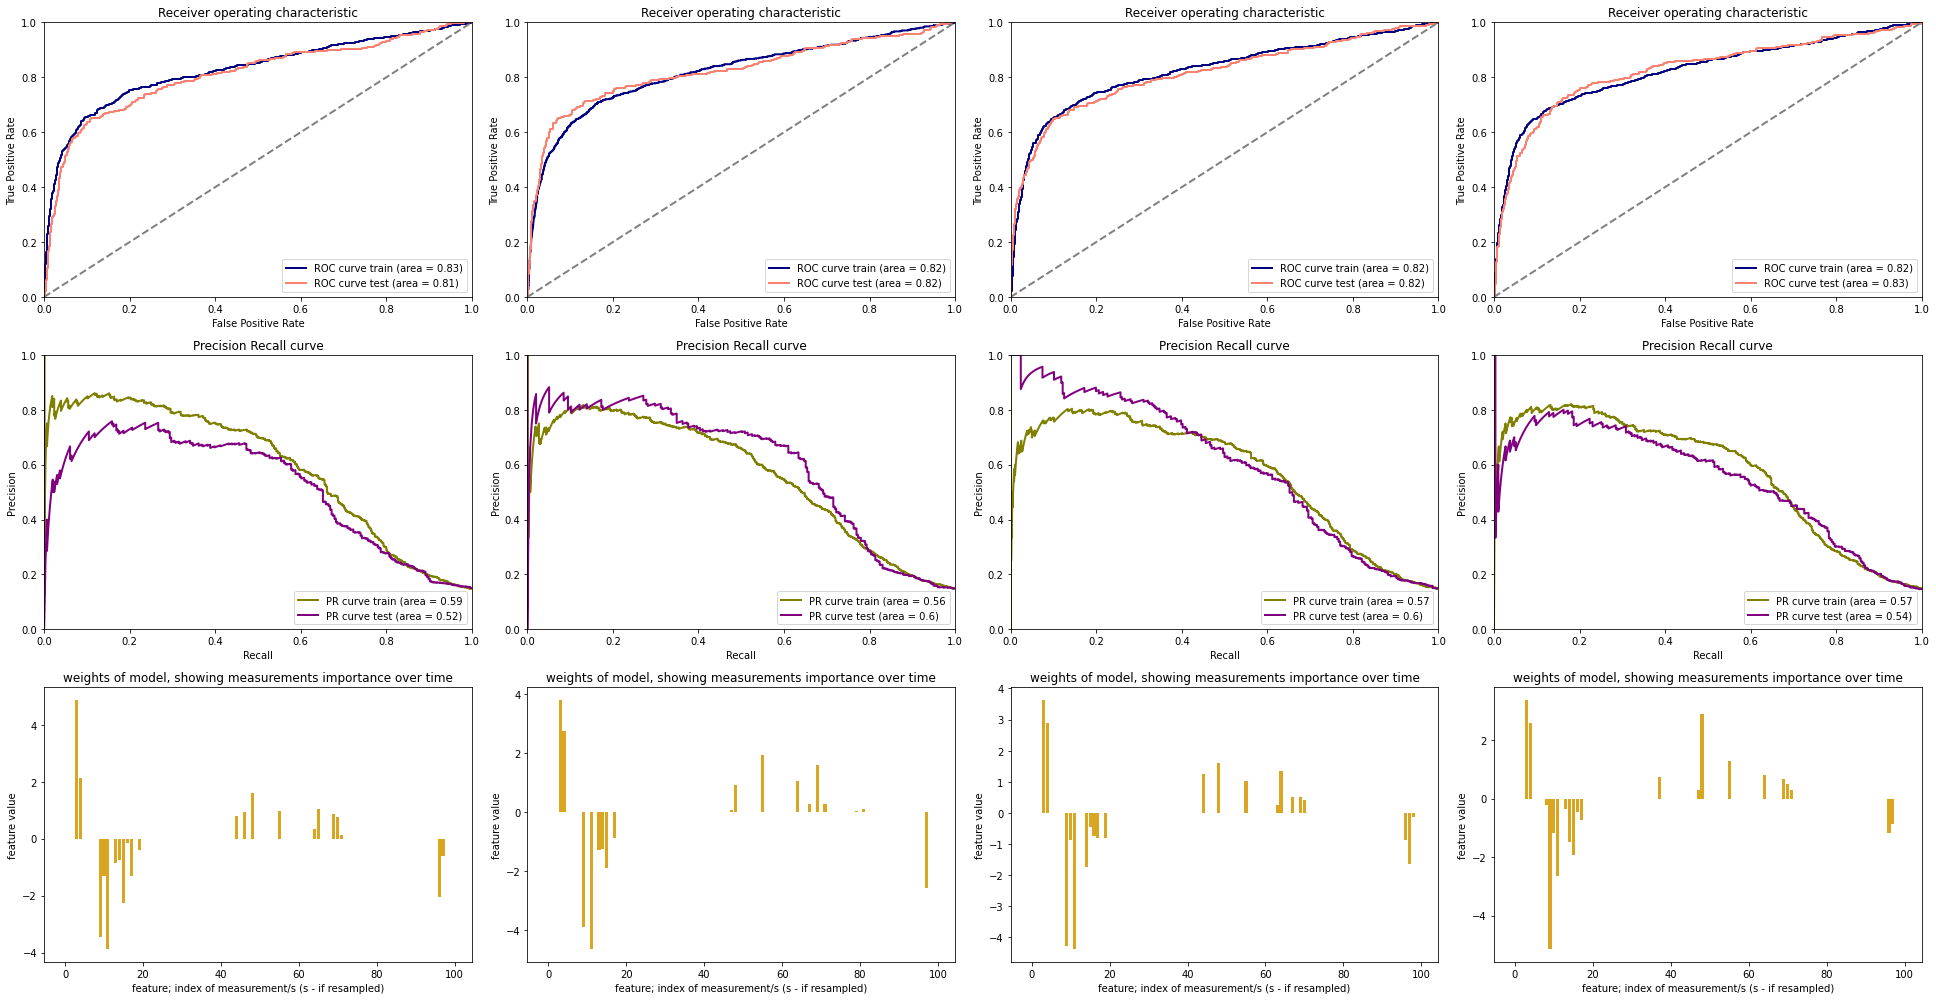

In [74]:
X = np.array(df_adj_shuff_tr['Pressure_stretch_norm_cols'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models3 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models3
show_cv_results(cv_models3, X, y, kfolds)

### Train on downsampled padded data non-normalized

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds


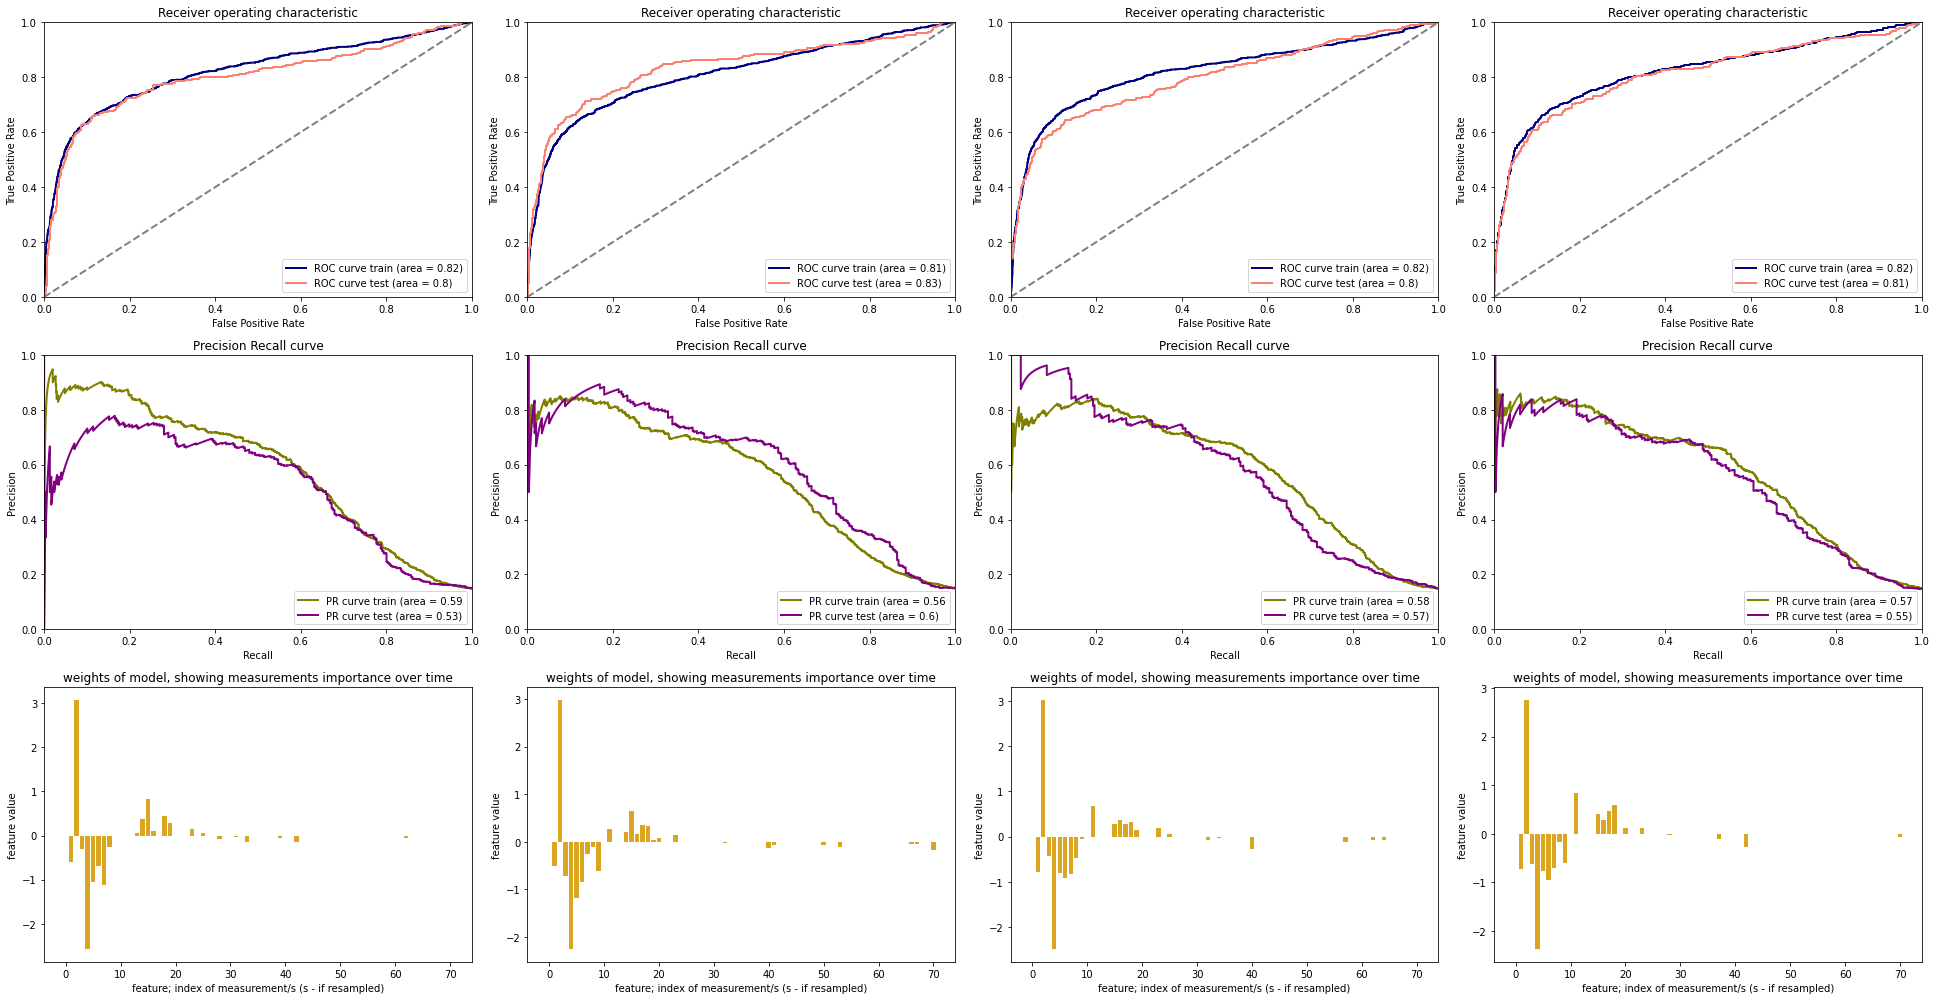

In [75]:
X = np.array(df_adj_shuff_tr['Pressure_downscale'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models4 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models4
show_cv_results(cv_models4, X, y, kfolds)

### Train on downsampled padded data normalized withing cycles

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds


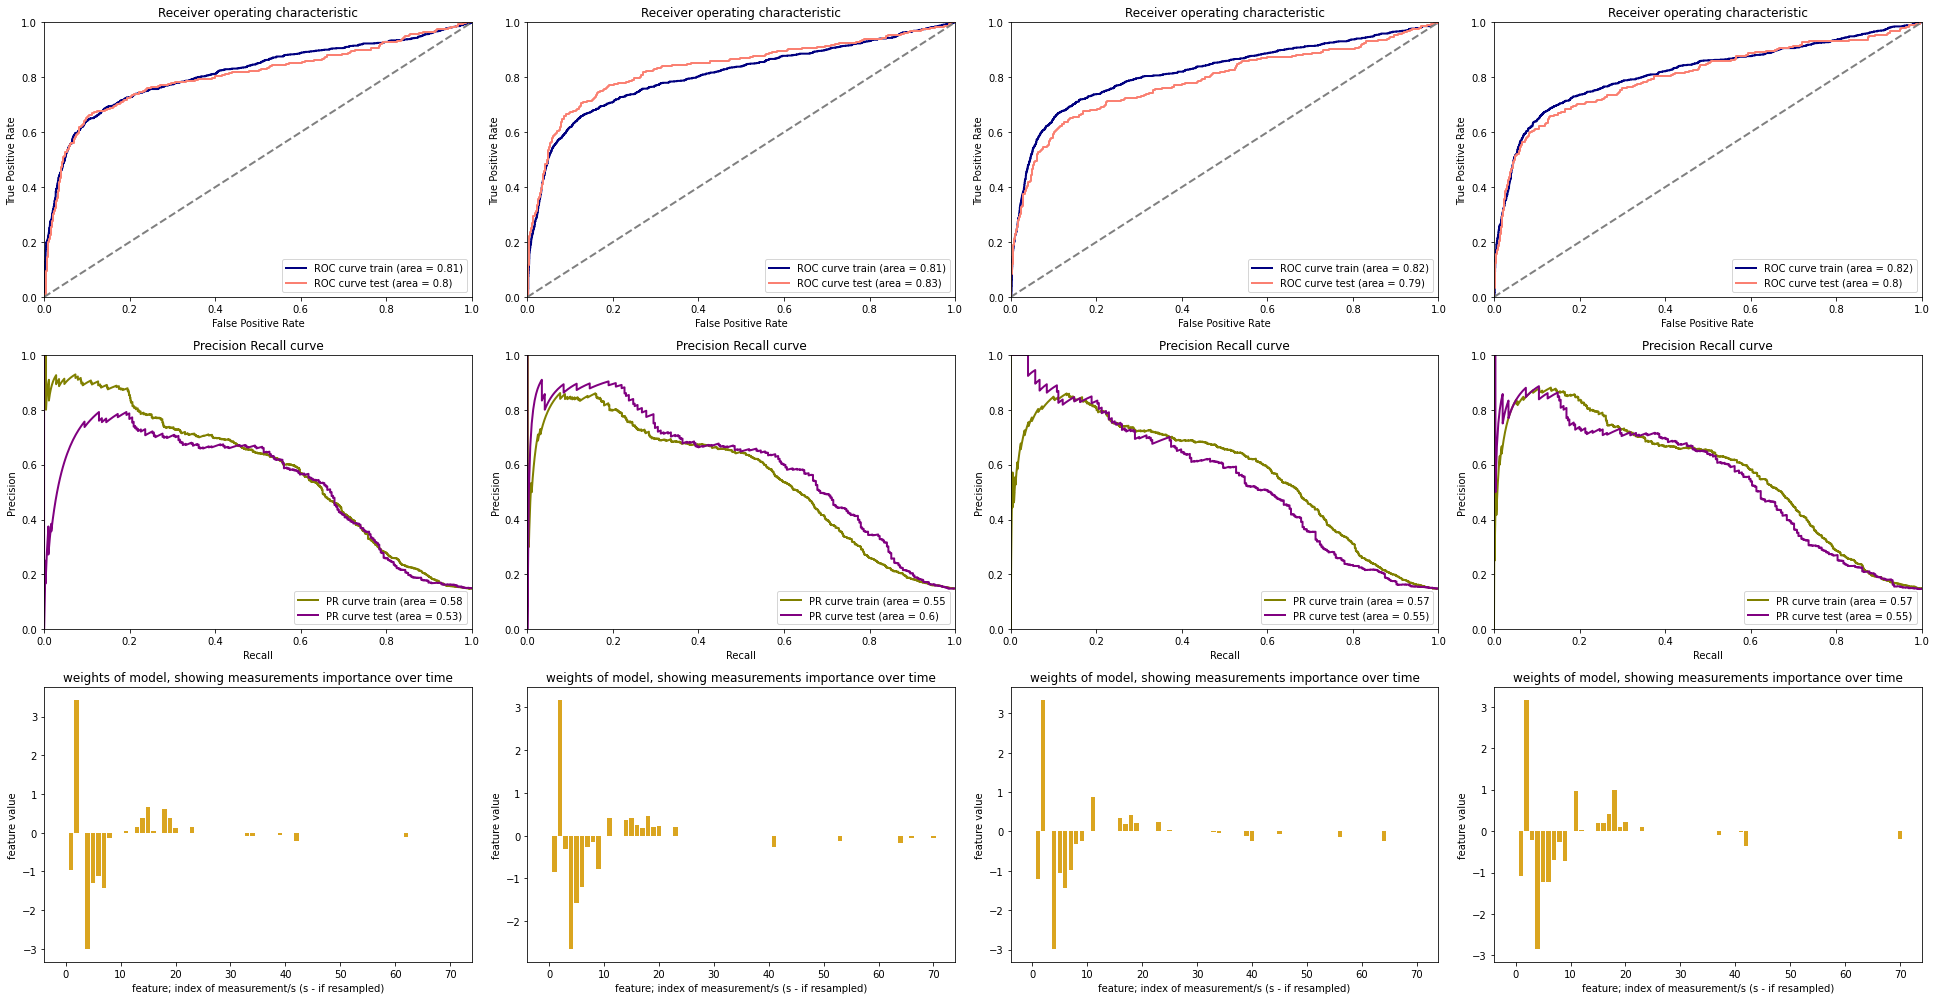

In [76]:
X = np.array(df_adj_shuff_tr['Pressure_downscale_norm'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models5 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models5
show_cv_results(cv_models5, X, y, kfolds)

### Train on downsampled padded data normalized withing columns

C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall) #compute f1 on all thresholds
C:\Users\Jan\AppData\Local\Temp\ipykernel_9572\3647978124.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + rec

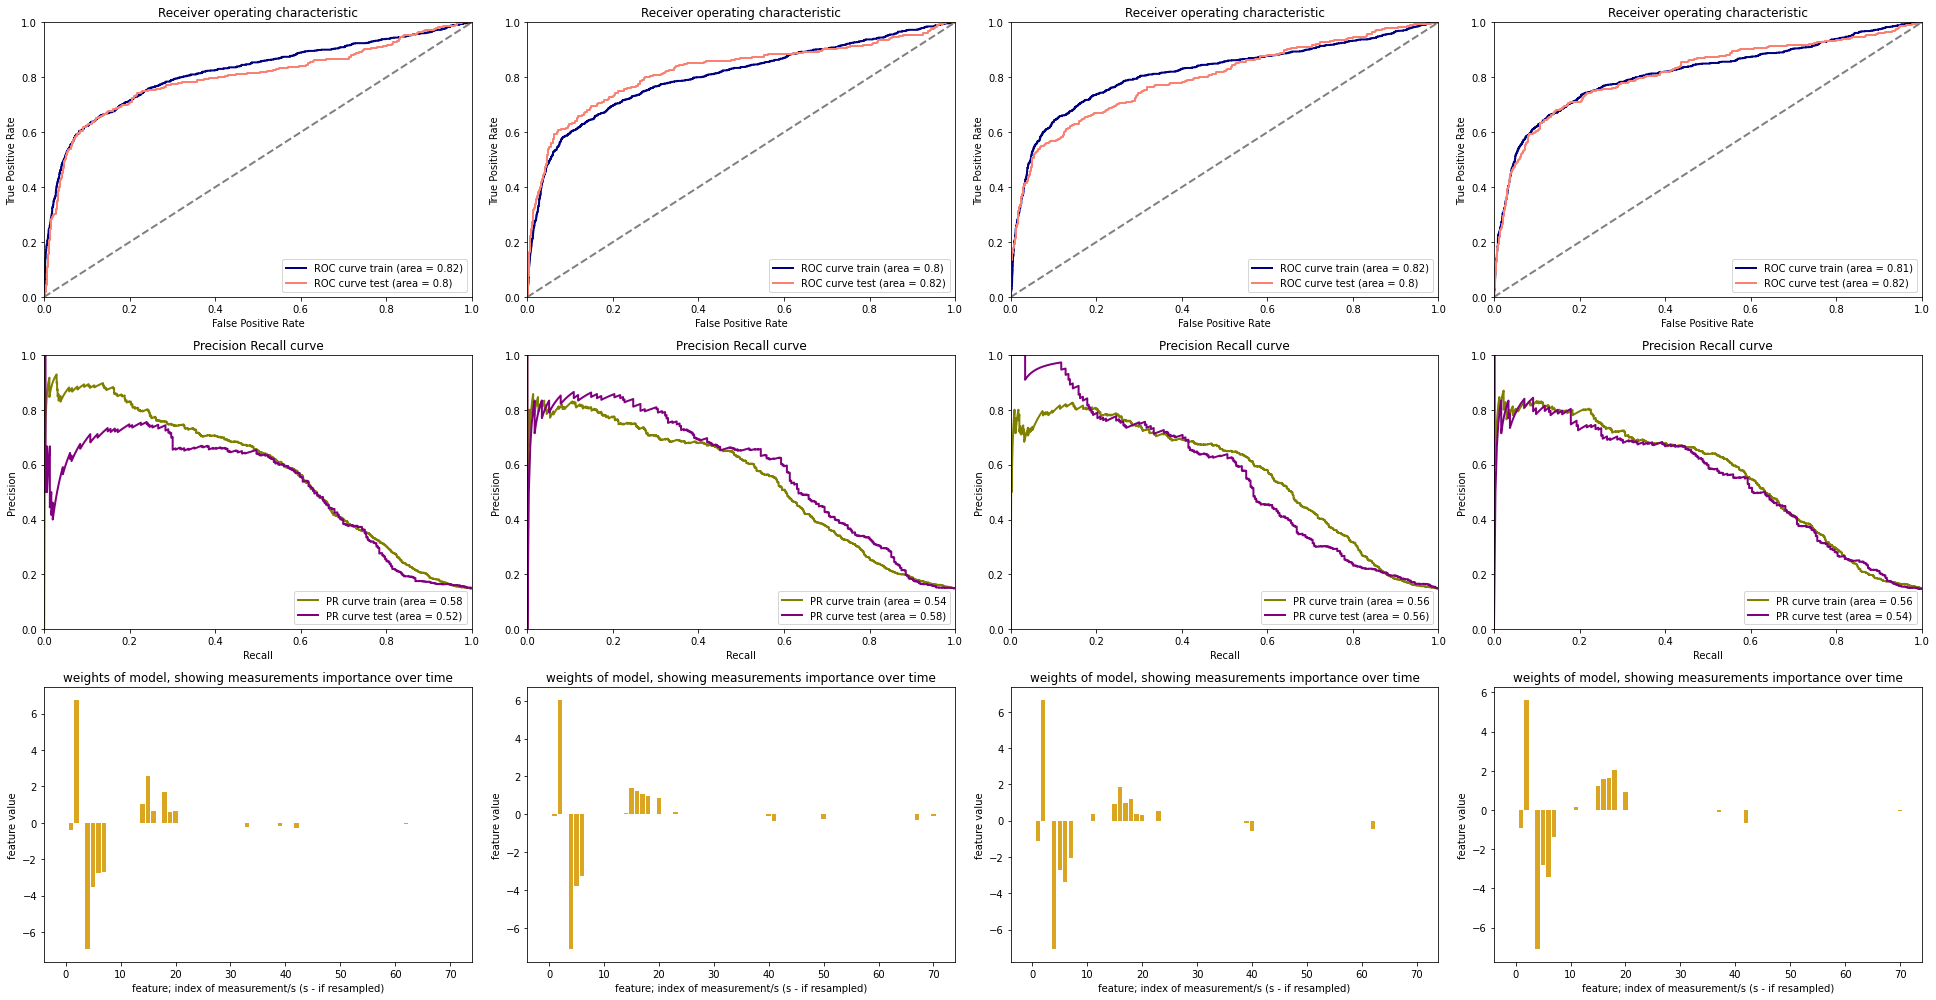

In [77]:
X = np.array(df_adj_shuff_tr['Pressure_downscale_norm_cols'].tolist()) #Pressure_stretch Pressure_downscale Pressure_downscale_norm Pressure_stretch_norm Pressure_downscale_norm_cols Pressure_stretch_norm_cols
y = y

est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
cv_models6 = cross_validate(est, X, y, cv=kfolds, scoring=get_all_scores, return_train_score=True, return_estimator=True)
cv_models6
show_cv_results(cv_models6, X, y, kfolds)

## Compare results of modeling

In [78]:
cv_models_groups = [[cv_models1,'stretched'],[cv_models2,'stretched normalized cycles'],[cv_models3,'stretched normalized columns'],
                    [cv_models4,'padded'],[cv_models5,'padded normalized cycles'],[cv_models6,'padded normalized columns']]
scores_train, scores_test = [], []
for cv_models, cv_models_desc in cv_models_groups:
    train_roc_mean, train_roc_std = np.mean(cv_models['train_roc']), np.std(cv_models['train_roc'])
    test_roc_mean, test_roc_std = np.mean(cv_models['test_roc']), np.std(cv_models['test_roc'])
    
    train_pr_mean, train_pr_std = np.mean(cv_models['train_pr']), np.std(cv_models['train_pr'])
    test_pr_mean, test_pr_std = np.mean(cv_models['test_pr']), np.std(cv_models['test_pr'])
    
    #metrics based on top F1 thresholds. In theory, top F1 thresohlds should be found only in train and then applied to test
    #due to time spent on this project, we will just check how ideal thresholds for train and test are different. If they are too much different, it may be sign of overfitting
    train_topf1_mean, train_topf1_std = np.mean(cv_models['train_topf1']), np.std(cv_models['train_topf1'])
    test_topf1_mean, test_topf1_std = np.mean(cv_models['test_topf1']), np.std(cv_models['test_topf1'])
    
    train_recall_topf1_mean, train_recall_topf1_std = np.mean(cv_models['train_recall_at_topf1']), np.std(cv_models['train_recall_at_topf1'])
    test_recall_topf1_mean, test_recall_topf1_std = np.mean(cv_models['test_recall_at_topf1']), np.std(cv_models['test_recall_at_topf1'])
    
    train_precision_topf1_mean, train_precision_topf1_std = np.mean(cv_models['train_precision_at_topf1']), np.std(cv_models['train_precision_at_topf1'])
    test_precision_topf1_mean, test_precision_topf1_std = np.mean(cv_models['test_precision_at_topf1']), np.std(cv_models['test_precision_at_topf1'])
    
    train_acc_topf1_mean, train_acc_topf1_std = np.mean(cv_models['train_accuracy_at_topf1']), np.std(cv_models['train_accuracy_at_topf1'])
    test_acc_topf1_mean, test_acc_topf1_std = np.mean(cv_models['test_accuracy_at_topf1']), np.std(cv_models['test_accuracy_at_topf1'])
    
    train_thr_topf1_mean, train_thr_topf1_std = np.mean(cv_models['train_topf1_threshold']), np.std(cv_models['train_topf1_threshold'])
    test_thr_topf1_mean, test_thr_topf1_std = np.mean(cv_models['test_topf1_threshold']), np.std(cv_models['test_topf1_threshold'])
    
    scores_train.append([cv_models_desc,train_roc_mean,train_roc_std,train_pr_mean,train_pr_std,train_topf1_mean,train_topf1_std,train_recall_topf1_mean,
                         train_recall_topf1_std,train_precision_topf1_mean,train_precision_topf1_std,train_acc_topf1_mean,train_acc_topf1_std,
                         train_thr_topf1_mean,train_thr_topf1_std])

    scores_test.append([cv_models_desc,test_roc_mean,test_roc_std,test_pr_mean,test_pr_std,test_topf1_mean,test_topf1_std,test_recall_topf1_mean,
                        test_recall_topf1_std,test_precision_topf1_mean,test_precision_topf1_std,test_acc_topf1_mean,test_acc_topf1_std,
                        test_thr_topf1_mean,test_thr_topf1_std])
    
results_train = pd.DataFrame(scores_train, columns=['data preprocessing',
                                              'train roc auc mean', 'train roc auc std','train pr auc mean', 'train pr auc std', 'train top F1 mean', 'train top F1 std',
                                              'train recall* mean', 'train recall* std', 'train precision* mean', 'train precision* std', 'train accuracy* mean', 'train accuracy* std',
                                              'train top F1 threshold mean', 'train top F1 threshold std'])
results_test = pd.DataFrame(scores_test, columns=['data preprocessing',
                                              'test roc auc mean', 'test roc auc std','test pr auc mean', 'test pr auc std', 'test top F1 mean', 'test top F1 std',
                                              'test recall* mean', 'test recall* std', 'test precision* mean', 'test precision* std', 'test accuracy* mean', 'test accuracy* std',
                                              'test top F1 threshold mean', 'test top F1 threshold std'])

display(results_train)
print('*at top F1 threshold based on train')
display(results_test)
print('*at top F1 threshold based on test. Top F1 thresholds between train and test should no differ and ideally only one threshold should have been used for this metrics')

data preprocessing  train roc auc mean  train roc auc std  \
0                     stretched            0.829225           0.002554   
1   stretched normalized cycles            0.824431           0.003635   
2  stretched normalized columns            0.823305           0.002619   
3                        padded            0.818374           0.004926   
4      padded normalized cycles            0.815579           0.005755   
5     padded normalized columns            0.813262           0.006301   

   train pr auc mean  train pr auc std  train top F1 mean  train top F1 std  \
0           0.591257          0.011626           0.609958          0.011001   
1           0.600320          0.012592           0.613885          0.006634   
2           0.572683          0.013257           0.596079          0.011372   
3           0.574722          0.011247           0.591704          0.008265   
4           0.565790          0.012265           0.590534          0.007189   
5           0.558786          0.013461           0.580715          0.008851   

   train recall* mean  train recall* std  train precision* mean  \
0            0.592500           0.020123               0.629201   
1            0.614494           0.006151               0.613575   
2            0.589965           0.017212               0.603171   
3            0.560919           0.010696               0.626314   
4            0.582353           0.018749               0.599496   
5            0.584891           0.012001               0.576824   

   train precision* std  train accuracy* mean  train accuracy* std  \
0              0.015560              0.887691             0.003321   
1              0.015135              0.885356             0.003541   
2              0.021820              0.881432             0.004968   
3              0.012706              0.885230             0.002737   
4              0.006349              0.880344             0.000673   
5              0.012091              0.874793             0.003175   

   train top F1 threshold mean  train top F1 threshold std  
0                     0.239598                    0.013308  
1                     0.237368                    0.006845  
2                     0.223613                    0.005693  
3                     0.241723                    0.006209  
4                     0.236362                    0.006351  
5                     0.212386                    0.002543

*at top F1 threshold based on train


data preprocessing  test roc auc mean  test roc auc std  \
0                     stretched           0.820160          0.006136   
1   stretched normalized cycles           0.813837          0.007915   
2  stretched normalized columns           0.818651          0.006281   
3                        padded           0.811048          0.014154   
4      padded normalized cycles           0.807594          0.017206   
5     padded normalized columns           0.807857          0.011092   

   test pr auc mean  test pr auc std  test top F1 mean  test top F1 std  \
0          0.580077         0.035111          0.609498         0.027542   
1          0.588781         0.031953          0.611461         0.021679   
2          0.566962         0.035398          0.596771         0.025591   
3          0.562935         0.027142          0.590594         0.019902   
4          0.556213         0.026416          0.584998         0.019642   
5          0.550390         0.023954          0.582752         0.016066   

   test recall* mean  test recall* std  test precision* mean  \
0           0.609156          0.028211              0.610335   
1           0.625252          0.028928              0.599023   
2           0.611673          0.030215              0.584881   
3           0.578705          0.026380              0.606060   
4           0.588860          0.046915              0.583812   
5           0.576171          0.032333              0.592416   

   test precision* std  test accuracy* mean  test accuracy* std  \
0             0.031760             0.883903            0.008721   
1             0.024012             0.881903            0.006827   
2             0.042036             0.876889            0.011245   
3             0.042937             0.880531            0.009610   
4             0.011404             0.876249            0.002448   
5             0.032397             0.877393            0.007057   

   test top F1 threshold mean  test top F1 threshold std  
0                    0.229299                   0.018540  
1                    0.229064                   0.012617  
2                    0.217518                   0.022278  
3                    0.231256                   0.023758  
4                    0.227533                   0.014929  
5                    0.218318                   0.015728

*at top F1 threshold based on test. Top F1 thresholds between train and test should no differ and ideally only one threshold should have been used for this metrics


### Conclusion of models comparison

In previous process we fitted several groups of models using cross validation. The differences were between _pressure_ scaling and normalization. As we can see from all the __test__ results, that ~ROC AUC is slightly over `0.8` for all models, while precision-recall curve AUC is generally slightly less than `0.6`, with recall and precision on best thresholds having similar values.

Also, from features coefficients, we can see, that algorithm is trained mostly to identify situations, where pressure raises for short time, then quickly drops, and then raises again. The real failure is (according to problem description) represented by pressure drop. Because of this, we could ask why algorithm found also positive coefficients for pressure before and after failrue, if they don't represent the real failure. Theoretical explanation of this could be such, that algorithm knows real pressure value at given moment. So if it would only learned negative coefficients without surrounding positive, it would mark as _failure_ also situations, where pressure is not large enough on the beginning, because pump started slowly or later, which is not real failure. The same applies to positive coefficients after the failure. If they would not be there, the algorithm would detect as failure also cases, where pump already finished its cycle correctly.

The final remarks and important points are following:
 - Models are not overfitted, as train and test scores are similar, and corresponding charts shows similar lines for both train and test
 - As ROC AUC is ~ `0.8` for all test sets, we can say that models were able to score random _pump failure_ higher than random _not-pump failure_ in ~80% of cases
 - Accuracy, precision, recall and F1 scores are based on best thresholds found in __corresponding sets__. This is not ideal case for test sets, better would be to use thresholds based on train. For that reason, we should at least watch whether train and test F1 ideal thresholds are similar (which is the case). We will use train thresholds to final model when testing on final test set.
 - Approximate accuracy for test sets is slightly above 85%, which can be interpreted as _85% of all test set predictions are correct_
 - As precision on best threshold is generally around `0.6` we can say, that in ~60% of cases where model marked cycle as pump failure, it was correct evaluation.
 - Because average recall is also approximatelly `0.6`, that can be interpreted as ~60% of actual pump failures (from test set) is captured by the model.
 
#### Models from different preprocessing differencies
 - Models with no pressure normalization have little higher ROC AUC.
 - We can see that models with pressure normalized over columns has lower precision-recall AUC than other models.
 - Models normalized over cycles are comparable with non-normalized models in terms of percision-recall AUC.
 - Stretched models are little better than padded models, in ROC AUC and precision-recall AUC and usually also in recall and precision on best threshold.
 - For reasons above, when training final model, we will use stretched data normalized over cycles (we could also use stretched data non-normalized)

# Train final model
Now we train final model from all folds. We will use stretched pressure data, with normalization over individual cycles

In [79]:
est = lr(max_iter=500, penalty='l1', C=.2, solver='saga')
X_train = np.array(df_adj_shuff_tr['Pressure_stretch_norm'].tolist())
y_train = df_adj_shuff_tr['PumpFailed'].astype(int)
est.fit(X_train, y_train)

#score on train, find best F1 threshold
scores = get_all_scores(est, X_train, y_train)
scores

{'roc': 0.8235703542951187,
 'pr': 0.6000515187355528,
 'recall_at_topf1': 0.6192893401015228,
 'precision_at_topf1': 0.6079734219269103,
 'topf1': 0.6135792120704107,
 'topf1_threshold': 0.23622680482377062,
 'accuracy_at_topf1': 0.8843937875751503}

In [80]:
y_pred_train_proba = est.predict_proba(X_train)[:,1]
y_pred_train_thr = np.array(y_pred_train_proba > scores['topf1_threshold']).astype(int)

## Running model on test set
We do predictions on test sets

In [81]:
X_test = np.array(df_adj_shuff_ts['Pressure_stretch_norm'].tolist())
y_test = df_adj_shuff_ts['PumpFailed'].astype(int)

y_pred_test_proba = est.predict_proba(X_test)[:,1]
y_pred_test_thr = np.array(y_pred_test_proba > scores['topf1_threshold']).astype(int) #use threshold from train F1

## Show results
Here we show and explain some results

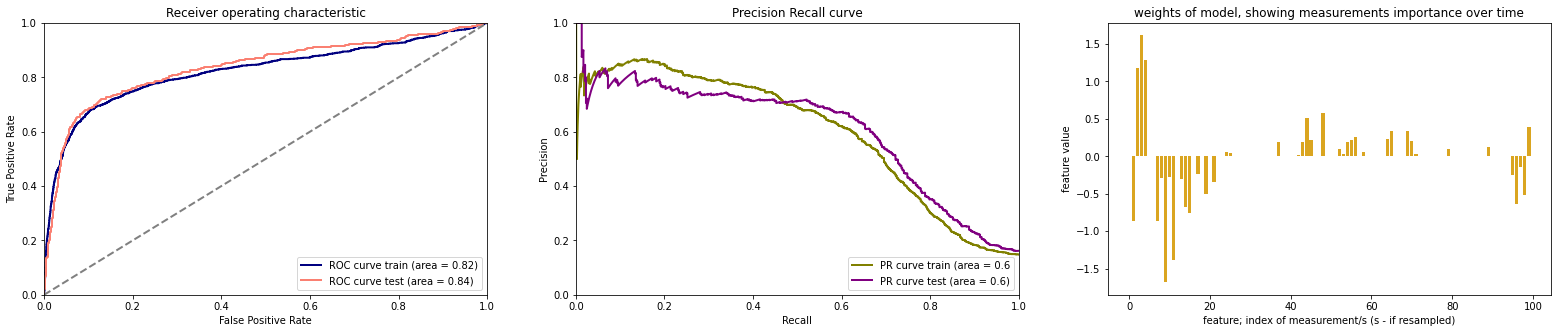

train      test
roc        0.823570  0.837046
pr         0.600052  0.602886
f1         0.613579  0.638971
recall     0.619289  0.616412
precision  0.607973  0.663244
accuracy   0.884394  0.888242

threshold used for F1, recall, precision, accuracy: 0.23622680482377062
dataset shapes: train: (7984, 100), test: (3266, 100)
dataset class counts and positive ratio: train {0: 6802, 1: 1182}, positive ratio: 0.15 | test: {0: 2742, 1: 524}, positive ratio: 0.16
# machines in train: 280, with positive samples: 206, with negative samples: 226
# machines in test: 94, with positive samples: 77, with negative samples: 79
individual model coefs: 
[ 0.         -0.85889311  1.18010315  1.61427508  1.28407493  0.
  0.         -0.86668565 -0.28923861 -1.68351205 -0.27535062 -1.37790203
  0.         -0.30491479 -0.67136863 -0.75546082  0.         -0.23805138
  0.         -0.50402443  0.         -0.34444866  0.          0.
  0.06131975  0.04175287  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.19197845  0.          0.          0.          0.
  0.01164357  0.1901512   0.51256921  0.21272545  0.          0.
  0.57200848  0.   

In [82]:
pr_auc_tr = scores['pr']
roc_auc_tr = scores['roc']
recall_tr = scores['recall_at_topf1']
precision_tr = scores['precision_at_topf1']
accuracy_tr = scores['accuracy_at_topf1']
F1_tr = scores['topf1']
precision_tr_curve, recall_tr_curve, _ = precision_recall_curve(y_train, y_pred_train_proba)
fpr_tr_curve, tpr_tr_curve, _ = roc_curve(y_train, y_pred_train_proba)

pr_auc_ts = average_precision_score(y_test, y_pred_test_proba)
roc_auc_ts = roc_auc_score(y_test, y_pred_test_proba)
recall_ts = recall_score(y_test, y_pred_test_thr)
precision_ts = precision_score(y_test, y_pred_test_thr)
accuracy_ts = accuracy_score(y_test, y_pred_test_thr)
F1_ts = 2 * (precision_ts * recall_ts) / (precision_ts + recall_ts)
precision_ts_curve, recall_ts_curve, _ = precision_recall_curve(y_test, y_pred_test_proba)
fpr_ts_curve, tpr_ts_curve, _ = roc_curve(y_test, y_pred_test_proba)

#charts
fig, (roc_chart, pr_chart, coef_chart) = plt.subplots(ncols=3, figsize=(27,5))
plot_single_curve_pair(roc_chart, fpr_tr_curve, tpr_tr_curve, fpr_ts_curve, tpr_ts_curve, roc_auc_tr, roc_auc_ts, mode='roc')
plot_single_curve_pair(pr_chart, recall_tr_curve, precision_tr_curve, recall_ts_curve, precision_ts_curve, pr_auc_tr, pr_auc_ts, mode='pr')
plot_coefs(coef_chart, pd.Series(est.coef_[0]))

#final result df
threshold_used = scores['topf1_threshold']
index_final_result = ['roc','pr','f1','recall','precision','accuracy']
columns_final_result = ['train','test']
final_result = [
[roc_auc_tr,roc_auc_ts],
[pr_auc_tr,pr_auc_ts],
[F1_tr,F1_ts],
[recall_tr,recall_ts],
[precision_tr,precision_ts],
[accuracy_tr,accuracy_ts]
]

#class counts and rations
tr_c = y_train.value_counts().to_dict()
tr_cr = round(tr_c[1]/(tr_c[0]+tr_c[1]),2)
ts_c = y_test.value_counts().to_dict()
ts_cr = round(ts_c[1]/(ts_c[0]+ts_c[1]),2)

#machines counts per classes
tr_m_c = len(df_adj_shuff_tr['MachineId'].unique())
tr_m_c_pos = len(df_adj_shuff_tr[df_adj_shuff_tr['PumpFailed'] == True]['MachineId'].unique())
tr_m_c_neg = len(df_adj_shuff_tr[df_adj_shuff_tr['PumpFailed'] == False]['MachineId'].unique())
ts_m_c = len(df_adj_shuff_ts['MachineId'].unique())
ts_m_c_pos = len(df_adj_shuff_ts[df_adj_shuff_ts['PumpFailed'] == True]['MachineId'].unique())
ts_m_c_neg = len(df_adj_shuff_ts[df_adj_shuff_ts['PumpFailed'] == False]['MachineId'].unique())

plt.show()
display(pd.DataFrame(final_result, columns=columns_final_result, index=index_final_result))
print('threshold used for F1, recall, precision, accuracy: {}'.format(threshold_used))
print('dataset shapes: train: {}, test: {}'.format(X_train.shape,X_test.shape))
print('dataset class counts and positive ratio: train {}, positive ratio: {} | test: {}, positive ratio: {}'.format(tr_c, tr_cr, ts_c, ts_cr))
print('# machines in train: {}, with positive samples: {}, with negative samples: {}'.format(tr_m_c, tr_m_c_pos, tr_m_c_neg))
print('# machines in test: {}, with positive samples: {}, with negative samples: {}'.format(ts_m_c, ts_m_c_pos, ts_m_c_neg))
print('individual model coefs: \n{}'.format(est.coef_[0]))

## Conlcusion of test set performance
We built a model, that is able to detect pump failure from recording of measurements. The results on unseen (test) data are following:
- The model is able to correctly give higher probability of failure to randomly selected failure sample over randomly selected non-failure sample, in more than __82%__ cases
- The model is able to correctly classify almost __89%__ of cycles measurements, considering their real distribution, adjusted by classifying maximally 100 measurements per machine
- More than __66%__ of cycles marked as _pump failure_ actually represents pump failure, however, this number is much higher on test than train set (60%), thus we should be careful with interpretation, and stick to more conservative interpretation, based on average precision score and PR curve. So in reality we can say, that __stable precision__ will be around or slightly above __60%__, as test score 66% on specific threshold (even based on train) can be caused by some data noisyness.
- Around __60%__ of pump failures are correctly detected as pump failure

# Ideas for future

Here are some ideas for making the whole thing better

 - There are some cases where pump failure was not present, although there was huge drop in pressure. This seems like that there was some small _pre-cycle_ (accidental start or something) before the main cycle. These drops are (at least according to sample charts) usually much more longer and deeper than drops from pump failures. This could be captured by better data preprocessing (for example when pressure drops to exactly zero for several measurements, it's probably not failure, from what could be seen in charts), or by some non linear algorithms (as logistic regression from its nature cannot learn things like _if pressure drop size is within some bounds then it's fail_; it can learn only linear relationships) or by adding non-linear features
 - make additional features (such as variance, resampling to additional resolutions, differences or ratios between pressures, their means (or geometrical means for ratios), polynomial features, etc...)
 - Use additional algorithms, such as convolution neural network, which could theoretically detect parts with pressure drops
 - We could do some statistical tests (DeLong for instance) to compare precision-recall and ROC curves between various models
 - We could also use the information of slow start or slow end of cycle, if this factor is relibable and intentional (i.e. if slow start or slow end is based on machine settings and is not result of another evaluation, so we are able to get this information from real source in advance)
 - In theory, we could also use information about how many measurements machine had in past, as machines with more measurements are less faulty. However, we would need to do some research what is reason behind this behavior. For example, if faulty machine is discarded and no more used (thus no more measured) the simple reason for machines with more measurements being less faulty can be such, that they are time-proven (as mentioned before in this notebook). Eventhough this may technically look as good feature, it could actually lead to model behavior automatically predicting new machines to be faulty, while being less aware of failures on older machines, which is definitely not what we want. Simply said, we don't want to say _if that machine lasted for such many measurements without issue, it's cycles are without failures_, because, we would swap cause and result (in reality, machine had many measurements because it wasn't failing, so we should not say it's not failing now because it had many measurements in past)